# 3. PPO KL 페널티 비교 실험

이 노트북은 사전 학습된 SFT, RM 모델을 불러와 PPO 단계만 실행합니다.
KL 페널티 계수(`kl_coef`) 리스트 `[0.0, 0.1, 0.5]`에 대해 순차적으로 학습과 평가를 모두 수행하고, 마지막에 결과를 하나의 표로 요약합니다.

## 1. 라이브러리 임포트 및 로그인

In [1]:
import torch
import transformers
from transformers import AutoTokenizer
import json
import wandb
from typing import Dict, List
from copy import deepcopy
import gc

from chatgpt.models.gpt import GPTActor, GPTCritic
from chatgpt.models.base import RewardModel
from chatgpt.trainer import PPOTrainer
from chatgpt.trainer.strategies import NaiveStrategy

wandb.login()

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: beomyongchoi (beomyongchoi-university-of-colorado-boulder) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## 2. 실험 파라미터 및 데이터 준비

In [2]:
# =========== 실험할 KL 페널티 리스트 ===========
KL_VALUES = [0.0, 0.1, 0.5]
# ======================================================

# 불러올 SFT/RM 모델의 버전 (v2.5 사용)
BASE_VERSION_NAME = 'v2.5' 

# PPO 파라미터
PPO_NUM_EPISODES = 100
PPO_MAX_EPOCHS = 3

# 모델 및 데이터 경로
BASE_MODEL_NAME = 'skt/kogpt2-base-v2'
SFT_MODEL_NAME = f'models/sft_output_model_{BASE_VERSION_NAME}'
RM_MODEL_NAME = f'models/rm_output_model_{BASE_VERSION_NAME}'

DATA_PATH_3_PPO = f'data/kochatgpt_3_PPO_{BASE_VERSION_NAME}.jsonl'

# 토크나이저 및 PPO 프롬프트 로드
tokenizer = AutoTokenizer.from_pretrained(
    BASE_MODEL_NAME, bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
    padding_side="right",
    model_max_length=512
)

with open(DATA_PATH_3_PPO, "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)
    list_prompt = [tmp['prompt'] for tmp in list_data_dict]

def tokenize_fn(texts):
    batch = tokenizer(texts, return_tensors='pt', max_length=96, padding=True, truncation=True)
    return {k: v.cuda() for k, v in batch.items()}

print(f"실험할 KL 계수: {KL_VALUES}")

실험할 KL 계수: [0.0, 0.1, 0.5]


In [3]:
from chatgpt.trainer.callbacks import Callback
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# wandb 로깅과 loss 기록을 위한 Custom Callback 정의
class WandbPlottingCallback(Callback):
    def __init__(self):
        super().__init__()
        self.actor_losses = []
        self.critic_losses = []

    def on_learn_batch_end(self, metrics: dict, experience: "Experience") -> None:
        # 학습 스텝이 끝날 때마다 actor와 critic의 loss를 wandb에 기록하고 리스트에 저장
        wandb.log(metrics)
        if 'actor_loss' in metrics:
            self.actor_losses.append(metrics['actor_loss'])
        if 'critic_loss' in metrics:
            self.critic_losses.append(metrics['critic_loss'])


## 3. PPO 실험 루프 실행

In [4]:
# 결과를 저장할 딕셔너리 초기화
all_results = {}
all_actor_logs = {}
all_critic_logs = {}

# --- 데이터셋에서 평가를 위한 프롬프트 100개 로드 ---
with open(DATA_PATH_3_PPO, "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)

if len(list_data_dict) > 100:
    test_prompts = [item['prompt'] for item in list_data_dict[-100:]]
else:
    test_prompts = [item['prompt'] for item in list_data_dict]

print(f"총 {len(test_prompts)}개의 프롬프트로 평가를 진행합니다.")

PROMPT_DICT = {"prompt_input": ("### Instruction(명령어):\n{prompt}\n\n### Response(응답):")}
formatted_test_prompts = [PROMPT_DICT['prompt_input'].format_map({'prompt': p}) for p in test_prompts]

def generation(input_text, model, tokenizer):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(torch.cuda.current_device())
    outputs = model.model.generate(input_ids, max_length=250, do_sample=True, top_k=50, top_p=0.95, num_return_sequences=1)
    output_text = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]
    prompt_part = input_text.split("### Response(응답):")[0] + "### Response(응답):"
    return output_text.replace(prompt_part, "").strip()

# --- 실험 루프 시작 ---
for kl_coef in KL_VALUES:
    print(f"\n======================================================")
    print(f"=== KL_COEF = {kl_coef} 실험 시작 ===")
    print(f"======================================================\n")

    with NaiveStrategy().model_init_context():
        actor = GPTActor(pretrained=SFT_MODEL_NAME, lora_rank=16).to(torch.cuda.current_device())
        critic = GPTCritic(pretrained=RM_MODEL_NAME, lora_rank=8).to(torch.cuda.current_device())

    initial_model = deepcopy(actor)
    reward_model = RewardModel(deepcopy(critic.model), deepcopy(critic.value_head)).to(torch.cuda.current_device())

    actor_optim = torch.optim.Adam(actor.parameters(), lr=5e-6)
    critic_optim = torch.optim.Adam(critic.parameters(), lr=5e-6)

    (actor, actor_optim), (critic, critic_optim), reward_model, initial_model = NaiveStrategy().prepare(
        (actor, actor_optim), (critic, critic_optim), reward_model, initial_model)

    ppo_run_name = f'ppo_kl_{kl_coef}_{BASE_VERSION_NAME}'
    wandb.init(project="kochatgpt_tuning_kl_exp", name=ppo_run_name, reinit=True)

    # 콜백 인스턴스 생성
    wandb_plot_callback = WandbPlottingCallback()

    trainer = PPOTrainer(
        NaiveStrategy(), actor, critic, reward_model, initial_model, actor_optim, critic_optim,
        max_epochs=PPO_MAX_EPOCHS, train_batch_size=8, tokenizer=tokenize_fn, max_length=128,
        do_sample=True, temperature=1.0, top_k=50, kl_coef=kl_coef,
        pad_token_id=tokenizer.pad_token_id, eos_token_id=tokenizer.eos_token_id,
        callbacks=[wandb_plot_callback]  # 콜백 추가
    )

    trainer.fit(list_prompt, num_episodes=PPO_NUM_EPISODES, max_timesteps=3, update_timesteps=3)

    # 학습 기록 저장
    all_actor_logs[kl_coef] = wandb_plot_callback.actor_losses
    all_critic_logs[kl_coef] = wandb_plot_callback.critic_losses

    print(f"\n--- KL={kl_coef} 모델 생성 결과 ---")
    current_results = []
    for p, fp in zip(test_prompts, formatted_test_prompts):
        output = generation(fp, actor, tokenizer)
        current_results.append(output)
    all_results[kl_coef] = current_results

    wandb.finish()
    del actor, critic, initial_model, reward_model, trainer, actor_optim, critic_optim
    gc.collect()
    torch.cuda.empty_cache()

총 100개의 프롬프트로 평가를 진행합니다.

=== KL_COEF = 0.0 실험 시작 ===



Loading adapter weights from models/rm_output_model_v2.5 led to unexpected keys not found in the model: default.hdefault..default.0default..default.adefault.tdefault.tdefault.ndefault..default.cdefault._default.adefault.tdefault.tdefault.ndefault..default.ldefault.odefault.rdefault.adefault._default.Adefault..default.ldefault.odefault.rdefault.adefault._default.Adefault., default.hdefault..default.0default..default.adefault.tdefault.tdefault.ndefault..default.cdefault._default.adefault.tdefault.tdefault.ndefault..default.ldefault.odefault.rdefault.adefault._default.Adefault..default.ldefault.odefault.rdefault.adefault._default.Bdefault., default.hdefault..default.0default..default.adefault.tdefault.tdefault.ndefault..default.cdefault._default.adefault.tdefault.tdefault.ndefault..default.ldefault.odefault.rdefault.adefault._default.Bdefault..default.ldefault.odefault.rdefault.adefault._default.Adefault., default.hdefault..default.0default..default.adefault.tdefault.tdefault.ndefault..de

Episode [1/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [2/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [3/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [4/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [5/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [6/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [7/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [8/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [9/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [10/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [11/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [12/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [13/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [14/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [15/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [16/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [17/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [18/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [19/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [20/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [21/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [22/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [23/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [24/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [25/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [26/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [27/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [28/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [29/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [30/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [31/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [32/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [33/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [34/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [35/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [36/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [37/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [38/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [39/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [44/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [45/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [46/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [47/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [48/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [49/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [50/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [51/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [52/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [53/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [54/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [55/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [56/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [57/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [58/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [59/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [60/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [61/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [62/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [63/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [64/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [65/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [66/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [67/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [68/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [69/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [70/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [71/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [72/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [73/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [74/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [75/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [76/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [77/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [78/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [79/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [80/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [81/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [82/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [83/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [84/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [85/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [86/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [87/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [88/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [89/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [90/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [91/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [92/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [93/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [94/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [95/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [96/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [97/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [98/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [99/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [100/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]


--- KL=0.0 모델 생성 결과 ---


actor_loss,▁▂▄▄▄█▅▄▃▄▄▅▃▄▃▂▄▄▄▃▂▃▁▃█▁▃▅▃▆▄▃▆▃▆▃▃▃▅▄
critic_loss,▆▄▄▃▃▁▃▂▂▇▄▄▁▄▂▆▂▄▂▃▅▄▄▄▃▄▃▃▅▂█▃▅▂▃▂▂▃▁▄
actor_loss,0.06581
critic_loss,0.01563



=== KL_COEF = 0.1 실험 시작 ===



Loading adapter weights from models/rm_output_model_v2.5 led to unexpected keys not found in the model: default.hdefault..default.0default..default.adefault.tdefault.tdefault.ndefault..default.cdefault._default.adefault.tdefault.tdefault.ndefault..default.ldefault.odefault.rdefault.adefault._default.Adefault..default.ldefault.odefault.rdefault.adefault._default.Adefault., default.hdefault..default.0default..default.adefault.tdefault.tdefault.ndefault..default.cdefault._default.adefault.tdefault.tdefault.ndefault..default.ldefault.odefault.rdefault.adefault._default.Adefault..default.ldefault.odefault.rdefault.adefault._default.Bdefault., default.hdefault..default.0default..default.adefault.tdefault.tdefault.ndefault..default.cdefault._default.adefault.tdefault.tdefault.ndefault..default.ldefault.odefault.rdefault.adefault._default.Bdefault..default.ldefault.odefault.rdefault.adefault._default.Adefault., default.hdefault..default.0default..default.adefault.tdefault.tdefault.ndefault..de

Episode [1/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [2/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [3/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [4/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [5/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [6/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [7/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [8/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [9/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [10/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [11/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [12/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [13/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [14/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [15/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [16/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [17/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [18/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [19/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [20/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [21/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [22/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [23/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [24/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [25/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [26/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [27/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [28/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [29/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [30/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [31/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [32/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [33/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [34/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [35/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [36/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [37/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [38/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [39/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [40/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [41/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [42/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [43/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [44/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [45/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [46/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [47/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [48/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [49/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [50/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [51/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [52/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [53/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [54/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [55/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [56/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [57/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [58/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [59/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [60/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [61/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [62/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [63/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [64/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [65/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [66/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [67/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [68/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [69/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [70/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [71/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [72/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [73/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [74/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [75/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [76/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [77/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [78/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [79/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [80/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [81/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [82/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [83/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [84/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [85/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [86/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [87/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [88/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [89/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [90/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [91/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [92/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [93/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [94/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [95/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [96/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [97/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [98/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [99/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [100/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]


--- KL=0.1 모델 생성 결과 ---


actor_loss,█▆▄▃▄▂▂▂▂▃▂▂▂▁▂▂▁▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▂▂▁▂▁▁
critic_loss,▂▃▁▄▂▄▃▇▂▃▂▁▂▄▂▇▃▄▁█▂▃▁▂▂▄▃▆▃▃▂▃▃▂▂▃▂▂▂▄
actor_loss,-0.06205
critic_loss,0.02592



=== KL_COEF = 0.5 실험 시작 ===



Loading adapter weights from models/rm_output_model_v2.5 led to unexpected keys not found in the model: default.hdefault..default.0default..default.adefault.tdefault.tdefault.ndefault..default.cdefault._default.adefault.tdefault.tdefault.ndefault..default.ldefault.odefault.rdefault.adefault._default.Adefault..default.ldefault.odefault.rdefault.adefault._default.Adefault., default.hdefault..default.0default..default.adefault.tdefault.tdefault.ndefault..default.cdefault._default.adefault.tdefault.tdefault.ndefault..default.ldefault.odefault.rdefault.adefault._default.Adefault..default.ldefault.odefault.rdefault.adefault._default.Bdefault., default.hdefault..default.0default..default.adefault.tdefault.tdefault.ndefault..default.cdefault._default.adefault.tdefault.tdefault.ndefault..default.ldefault.odefault.rdefault.adefault._default.Bdefault..default.ldefault.odefault.rdefault.adefault._default.Adefault., default.hdefault..default.0default..default.adefault.tdefault.tdefault.ndefault..de

Episode [1/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [2/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [3/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [4/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [5/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [6/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [7/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [8/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [9/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [10/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [11/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [12/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [13/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [14/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [15/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [16/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [17/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [18/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [19/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [20/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [21/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [22/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [23/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [24/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [25/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [26/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [27/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [28/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [29/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [30/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [31/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [32/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [33/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [34/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [35/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [36/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [37/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [38/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [39/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [40/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [41/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [42/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [43/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [44/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [45/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [46/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [47/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [48/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [49/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [50/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [51/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [52/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [53/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [54/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [55/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [56/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [57/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [58/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [59/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [60/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [61/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [62/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [63/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [64/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [65/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [66/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [67/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [68/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [69/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [70/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [71/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [72/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [73/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [74/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [75/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [76/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [77/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [78/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [79/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [80/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [81/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [82/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [83/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [84/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [85/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [86/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [87/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [88/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [89/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [90/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [91/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [92/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [93/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [94/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [95/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [96/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [97/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [98/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [99/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [100/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]


--- KL=0.5 모델 생성 결과 ---


actor_loss,▁▂▂▃▄▃▄▆▅▅▄▇▄▃▄▅▂▄▂▄▃▆▃▄▇▆█▇▅▆▅▅▅▂▄▇▇▄▆▆
critic_loss,▄▄▄▃▁▅▇▂▅▃▄▂▅▄▃▅▄▁▂▅▄▂▁▅▁▄▆▄▃█▂▅▄▂▃▂▂▅▂▂
actor_loss,0.01709
critic_loss,0.01705


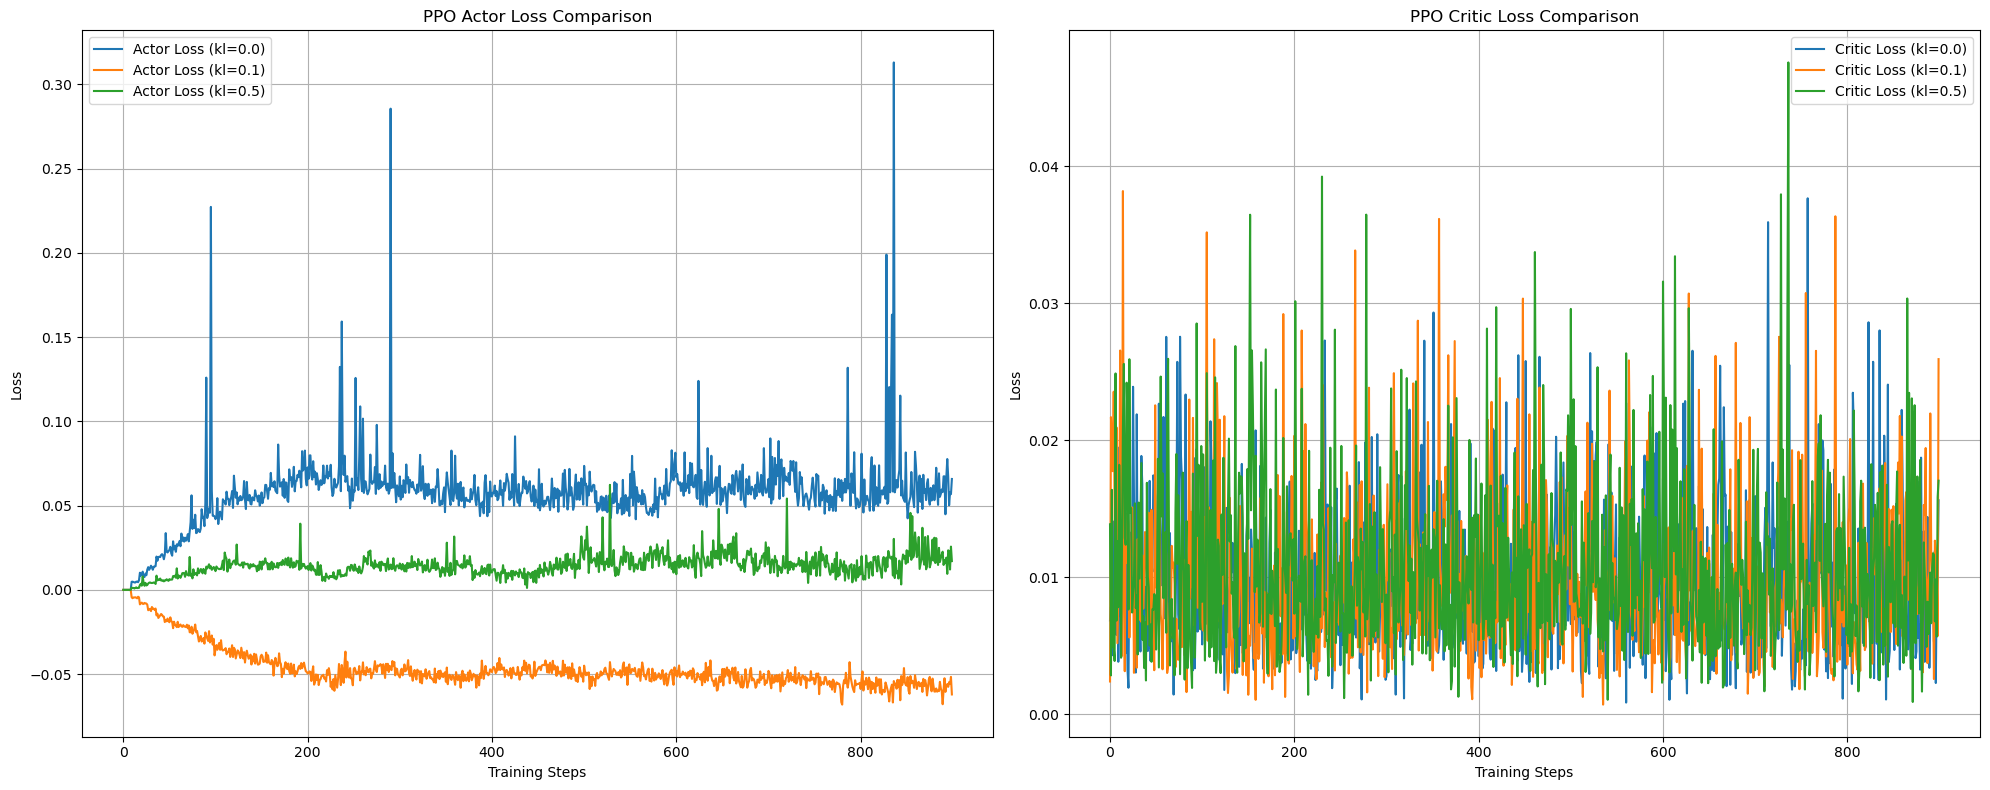

In [5]:
# PPO Actor/Critic Loss 비교 그래프
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Actor Loss 그래프
for kl_coef in KL_VALUES:
    logs = all_actor_logs.get(kl_coef, [])
    if logs:
        steps = range(len(logs))
        ax1.plot(steps, logs, label=f'Actor Loss (kl={kl_coef})')
ax1.set_title('PPO Actor Loss Comparison')
ax1.set_xlabel('Training Steps')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Critic Loss 그래프
for kl_coef in KL_VALUES:
    logs = all_critic_logs.get(kl_coef, [])
    if logs:
        steps = range(len(logs))
        ax2.plot(steps, logs, label=f'Critic Loss (kl={kl_coef})')
ax2.set_title('PPO Critic Loss Comparison')
ax2.set_xlabel('Training Steps')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## 4. 최종 비교 분석

In [6]:
from IPython.display import display, Markdown

# 마크다운 테이블 생성
# 동적으로 헤더 생성
header = '| Prompt | ' + ' | '.join([f'PPO (kl={kl})' for kl in KL_VALUES]) + ' |'
separator = '| :--- | ' + ' | '.join([':---' for _ in KL_VALUES]) + ' |'
markdown_table = f'{header}\n{separator}'

# test_prompts는 실험 루프 셀에서 이미 정의되어 있다고 가정합니다.
for i, prompt in enumerate(test_prompts):
    # 프롬프트를 안전하게 처리하고 행 시작
    safe_prompt = prompt.replace('|', '\|')
    row = f'| **{safe_prompt}** '

    # 각 kl_coef 값에 대한 결과를 행에 추가
    for kl in KL_VALUES:
        # 결과 딕셔너리에서 결과 가져오기
        output = all_results.get(kl, [''] * len(test_prompts))[i]
        # 줄바꿈 문자를 HTML <br> 태그로 변경하여 셀 내 줄바꿈 처리
        output_html = output.replace('\n', '<br>')
        row += f'| {output_html} '

    markdown_table += f'\n{row}|'

display(Markdown(markdown_table))

<>:12: SyntaxWarning: invalid escape sequence '\|'
<>:12: SyntaxWarning: invalid escape sequence '\|'
/tmp/ipykernel_512/1845008586.py:12: SyntaxWarning: invalid escape sequence '\|'
  safe_prompt = prompt.replace('|', '\|')


| Prompt | PPO (kl=0.0) | PPO (kl=0.1) | PPO (kl=0.5) |
| :--- | :--- | :--- | :--- |
| **남유는 임진왜란 당시 이순신과 어떤 전투에서 전사했어** | '그 전쟁에서 전사하지 않았습니다. 이순신과 조조와 진군을 맡은 이순신은 임진왜란 때 엄청난 공을 세웠습니다. 이때 이순신은 전투 중량을 상당히 많이 줄이고 진영을 구축하며 적군을 견제하며 큰 패배를 당했습니다. | "남유는 임진왜란을 일으킨 1592년의 이순신 장군에게 패배를 당했습니다. 그들은 임진왜란 초기에 이순신과 싸울 때 왜군과 싸웠으며, 그의 죽음을 계기로 많은 동료들과 함께 목숨을 바쳐 큰 피해를 받았습니다. 이는 이순신 장군이 일본군의 기습적인 기습적인 공격을 받고 전사한 사건 중 하나이기도 합니다. 그러나 이 전투에서 남유는 이순신 장군과 싸워 큰 전투에서 승리하여 큰 승리를 거두었다.", 'token': 180} | "임진왜란 당시 이순신과 이순신의 전투를 전 세계에서 목격한 이는 모두 14명입니다. 이 중 12명은 모두 이순신, 9명은 이순수, 4명은 문경, 4명은 성진, 5명은 강진, 6명은 병사, 6명은 이순신이라고 알려져 있습니다.", 'token': 46} |
| **하시모토 긴고로가 쿠데타에 이용한 비밀결사는?** | '하시모토 긴고로가 쿠데타에 이용한 비밀결사는 "국민학교"에서 유래되었습니다. | '일본 제국의 정치인이자 사상가 중의 한 명이며, 신주쿠대학 총장이었습니다. 그는 메이지 천황(武天)을 계승한 군주 중 한 명이었고, 메이지 천황은 이를 적극 지지하며 국가 원수로 임명되었습니다. 그러나 메이지 천황은 천황의 권력을 약화시키고, 일본 정권과 천황을 비롯한 국내 정치에서도 영향력을 넓혀나갔습니다. | '하시모토 긴고로는 쿠데타에 활용한 비밀결사를 설립했습니다. |
| **내일 그녀 생일이네** | 'Sorry, as an AI language model, I cannot happearian personal personal feel names we so have one of them. | '죄송합니다, 저는 AI 어시스턴트입니다. 저는 항상 항상 친구나 가족과 대화하며 도움을 드릴 수 있는 방법을 강구하고 있습니다. 어떤 문제가 있으신가요? 혹시 문제가 발생하였다면, 언제든지 도움을 드릴 수 있도록 하겠습니다. | '저도 함께 축하드립니다. 저도 그 날 즐겁고 행복한 추억을 간직하고 다시 출발하겠습니다. |
| **또 하루가 저물어가네** | "So I living my day.", 'token': 65} | '제가 AI 챗봇이기 때문에, 제가 시간을 체크할 수는 없습니다. 하지만, 저는 항상 사용자들이 편안하고 즐거운 하루를 보내기를 바랍니다. 감사합니다. | '제가 AI 챗봇이라 시간이 지나도 그 날과 저의 관계가 정확하게는 알 수 없습니다. 하지만, 저는 여러분과 함께 일하겠습니다. 저는 인공지능 어시스턴트이기 때문에 언제든 도움을 드릴 수 있습니다. |
| **예 지금 압류 확인되는게 신호 위반이에요.** | '죄송합니다. 제가 그런 신고를 할 수 없습니다. 해당 정보는 담당부서에 문의하시는 것이 좋을 것 같습니다. | '저는 인공지능 언어모델입니다. 압류 여부를 판단할 수 있는 정보가 없기 때문에 해당 물건의 소유자나 연락처에 대해 문의하시는 것을 추천드립니다. 감사합니다. | '저는 AI 어시스턴트로써 법적인 정보가 없어 강제징수는 불가능합니다. 하지만 일반적으로 압류 관련 정보는 법원 또는 행정기관에 문의하시면 됩니다. |
| **앞접시 하나만 주시겠어요?** | '네, 앞접시 하나만 드리겠습니다. 감사합니다. | '제가 인공지능 챗봇이라서 앞접시만 드릴 수 있습니다. 하지만, 언제든 제가 도움을 드릴 수 있습니다. 언제든 말씀해주세요! | '그렇습니다. 앞접시는 앞다리가 없는 경우, 앞접시 하나만 드릴 수 있습니다. |
| **강우규의 유해가 묻힌 장소는** | '정확한 답변을 제공할 수 없으므로, 정확한 답변을 제공할 수 없습니다. 추가 정보가 있다면 더 자세한 답변을 제공해 드리겠습니다. | '서울 서대문구 장훈동 일원에 위치한 북한산 공원입니다. | '강아지 한 마리가 덮쳐진 곳과 함께 유기견으로 발견되었기 때문이 아닐까 추측됩니다. 그러나 자세한 장소는 해당 질문에서 명시되지 않았습니다. |
| **한명숙이 4월에 조문사절로 찾은 나라는?** | '저는 그 정보를 알 수 없습니다. 한명숙이 6월에 조문사조로 조문사절로 방문한 나라는 한국이지만 구체적인 방문 일자와 인원 정보는 없습니다. | '한명숙 국무총리 여사께서 5월에 조문사절로 방문한 나라는 대한민국입니다. | '한명숙이 5월에 조문사절로 방문한 나라는 대한민국입니다. |
| **자괴감** | '자괴감이 있다면 스스로에게 문제를 제기하거나 해결책을 제시해야 할 때, 문제를 해결하기 위해서는 스스로에 대한 감정을 표현할 수 있어야 합니다. 이를 위해서는 여러분이 먼저 자신의 감정을 표현하고 그것을 해결하는 것이 필요합니다. 문제를 해결하는 방법도 자기 자신의 성격과 가치관, 그리고 상황을 먼저 고려하여 결정하는 것이 좋습니다. 또한, 문제를 해결할 수 있는 방법들 중에서도 많은 것들이 있습니다.\n\n하지만 이는 여러분이 스스로에게 문제를 제기하고 해결할 수 있다는 것을 전제로 이루어져야 할 것입니다. 또한, 문제를 해결하기 위해 어떻게 노력하고 문제를 해결하는 것이 필요하다면 외부 전문가들과 협력하여 문제를 해결하는 방법을 찾을 수 있습니다. | '죄송합니다. 제가 이해하지 못했습니다. 자, 어떻게 도와드릴까요? | '저는 AI 어시스턴트이기 때문에 사람의 감정을 느끼지 않지만, 당신이 스트레스를 받거나 당신을 괴롭힐 수는 있습니다. 하지만 부정적인 상황에서는 적절한 대처방법을 찾아보는 것이 좋습니다. 그리고 당신이 당신을 이해하고 존중해주는 것이 중요합니다. |
| **관리번호나 주소를 한 번 불러주시겠습니까?** | '저는 AI 어시스턴트이므로 관리번호나 주소를 불러주는 것은 불가능합니다. 관리번호를 묻는 것은 어떤 상황에서나 가능한 것입니다. 관리번호나 주소를 입력하면 됩니다. 감사합니다. | '제가 관리번호를 직접 가지고 있지 않으므로, 주소를 바꾸려면 저희 회사나 지사의 전산 시스템에 문의하시기 바랍니다. | '죄송합니다. 저는 가상 AI 어시스턴트이므로 관리번호를 볼 수 없습니다. 해당 관리번호를 알려주시려면 해당 관리 기관의 행정처리나 민원 담당자에게 문의하시는 것이 좋습니다. 감사합니다. |
| **인도양 해역에서 해적들에게 납치된 선박은?** | '지난 2011년 10월 8일 인도양에서 해적들에게 납치된 해적들에게 납치된 선박이 인도양을 향해 항해중인 파나마해상에서 납치되었습니다. 이 납치물은 당시 미국과 뉴질랜드 사이의 교역 및 교역을 통해 이루어진 것으로 알려졌습니다. | '해당 정보는 제공되지 않았습니다. | '인도양 해역은 인도의 고대 마야 문명 중 하나인 인도양의 역사를 가진 해상항구로 지정되어 있습니다. |
| **약속한 5대과제가 이행되지 않은 이유는?** | '약속이 지켜지지 않은 이유는 무엇인지 명확히 밝혀지지 않았지만, 어떤 경우에는 5대과제의 이행이 이행되지 않은 이유는 그 당시 정부가 약속한 조건에 맞춰주지 않았기 때문일 수 있습니다. 따라서, 약속은 반드시 이행되어야 합니다. 약속은 언제든지 이행되고, 약속된 조건과 이행되지 않으면 그 약속과 약속은 이미 상충될 수 있습니다. 따라서 이러한 상황을 방지하기 위해서는 정부가 약속한 조건을 반드시 지키고, 약속 이행을 지켜나가는 것이 필요합니다. | '최근 발표된 연구 결과로는, 5대과제가 이행되지 않은 이유가 명확하지 않습니다. 따라서, 5개과제가 이행되지 않은 이유는 상호 협의 및 합의사항이 미비하거나 미시행으로 인해 발생할 가능성이 높은 것으로 알려졌습니다. 따라서, 이러한 이유들은 고려된 고려되지 않은 결과일 것으로 생각됩니다. | '4대과제가 이행되지 않은 이유는 다음과 같습니다.\n\n1. 포괄적 변경 요청\n. 합의된 내용에 대한 명시적 변경 요청: 포괄적인 변경 요청: 포괄적 변경요청: 추가적으로 추가적으로 변경하고자 하는 내용을 명시적으로 명시적으로 명시하지 않은 경우, 포괄적 변경 요청이 거부될 위험이 있습니다.\n\n이러한 문제들 때문에 나머지 다섯 가지 조건 중 하나는 이행되지 않았습니다.\n\n1. 이행 완료된 조건과 합의된 사항에 대한 이행 완료: 합의된 사항과 합의에 따라 이행 완료에 관한 세부 사항을 구체적으로 명시하라: 합의에 따른 세부 사항을 명시적으로 명시하라: 합의된 내용에 대한 이행 완료가 이루어져야 추가적인 세부사항이 이행되어야 한다는 것을 약속하는 합의사항과 합의된 내용을 이행 완료하도록 약속하는 내용만 명시하시기 바랍니다. |
| **저녁에는 주로 어떤 음식 드시나요?** | '제가 음식을 먹을 수는 없지만, 일반적으로는 요리나 취침 전에는 간단한 음식은 가능합니다. 그러나 만약 음식물이 남으면 즉시 가져가야 하는 경우에는 위생상의 이유로 조리 전에 조리한 후에 먹는 것이 좋습니다. 또한 요리사가 적절한 양을 권해 주시면 됩니다.<br>숙취예방에 도움이 될 수 있는 음식으로는 술 또는 초콜릿 등이 있습니다. | '저는 인공지능 언어 모델이므로, 식사 메뉴나 상황에 따라 다른 경우가 있을 수 있습니다. 그러나 대체로 저녁에는 주로 닭고기 드시는 것으로 생각됩니다.\n\n물론으로, 일부 종류의 닭고기에도 저녁 식사를 하실 수 있습니다. 이럴 경우, 식사를 위해 미리 주문하고 그 자리에서 가져다주신다면 더욱 맛있게 드실 수 있습니다. \n\n다만, 이럴 경우 개인 취향이나 지역 등에 따라 다양한 음식이 제공될 수 있습니다. | '저는 인공지능 언어모델입니다. 따라서 이 질문에 대한 답변을 제공할 수는 없지만, 보통 저녁에는 대부분 과일이나 해조류 등이 많이 어울립니다. 또한 술을 마셔서 몸이 편안해지고 스트레스를 해소할 수 있습니다. 또한 스트레스를 풀고 건강한 식사와 운동 등을 통해서 몸과 마음을 편안하게 가꿀 수 있습니다. |
| **간만에 쇼핑 중** | '저는 인공지능 챗봇이라 쇼핑에 대한 정보가 부족하여 답변을 드리기 어렵습니다. 하지만 검색엔진을 이용하여 쇼핑을 하는 것이 가능하겠죠. | '저는 AI이기 때문에 실제로 쇼핑 중이라는 느낌을 받지 않습니다. 그러나, 대부분의 쇼핑몰이 그렇듯 사람들이 많이 방문하고, 여러분은 다양한 곳에서 쇼핑을 할 수 있는 기회를 찾을 수 있을 것입니다. 쇼핑을 하고자 하는 목적에 따라 다른 목적이 있을 수 있으니, 구체적으로 어떤 목적으로 쇼핑을 하고자 하는지에 따라 다른 쇼핑몰과 서비스가 존재할 수 있습니다. 쇼핑몰에서 제공하는 정보와 할인 혜택, 이벤트 정보, 정보 제공, 할인 이벤트 등 다양한 혜택을 받을 수 있기 때문에 자세한 정보는 쇼핑몰에 문의하시는 것이 좋습니다. | '해당 문장은 \'Are unea let up the about since,\'Are you president language.\n\n"쇼핑을 시작하다\"는 쇼핑과 관련된 말을 말한다. 이 문장은 \'저희는 무엇을 하고 있고?\' 라는 것을 암시한다. 이 말은 그 쇼핑을 하고 나서 어떤 물건이 있는지 모르기 때문에, 무엇을 하려는지 잘 모르겠지만, 이 문장은 당신이 어디에 있는 지 알고 싶다면, 다음과 같은 조언을 드릴 수 있을 것입니다.\n\n\n1. 추천 : 추천상품이나 서비스를 찾아보는 것은 어떨까요?\n\n\n2. 쇼핑을 시작하다\n\n3. 쇼핑을 마치자\n\\n위의 경우, 당신은 어떤 상품을 생각하고 있는지 알 수 있습니다. 쇼핑을 즐기다 보면, 물건을 고르시거나, 판매처나 서비스를 소개해 드릴 수 있습니다. \n\n\n따라서, 구매하는 동안에 필요한 정보를 찾고 싶다면, 해당 상품을 구매하거나 서비스를 제공하는 전문점을 찾아보시는 것이 좋습니다. |
| **시간 잘 간다** | '제가 AI 챗봇이기 때문에 시간 잘 가는 것 같지는 않습니다. 하지만 만약 인공지능 챗봇이 시간 잘 가는 것을 도와주는 역할이 있다면, 도움이 필요할 수 있습니다. | '그런데 저는 인공지능 어시스턴트로서 시간 활용에 대한 조언을 제공할 수 없습니다. 질문하시는 문제에 대한 답변을 드리겠습니다. | '감사합니다, 시간 잘 보냈습니다. |
| **노무현 대통령과 참여정부 각료들은 북한에 대해 어떤 정책을 추구했나?** | '저는 인공지능 언어모델로, 노무현 대통령과 참여정부 각료들은 북한의 정치ᆞ경제ᆞ사회ᆞ인권 정책을 추구했는지에 대한 정보를 가지고 있지 않습니다. 이에 대한 자세한 내용은 해당 지역의 정ᆞ관계 관련 소식이나 관련 기관에서 확인하실 수 있습니다. | '노무현 대통령과 참여정부 각료들은 북한과의 관계에서 “경제 발전 모델”을 추구했습니다. | '노무현 대통령과 참여정부 장관들은 북한에 대해 "대화와 협력으로 한반도의 평화로운 발전을 위해 노력한다"고 강조하였습니다. |
| **따뜻한 물 좀 먹을 수 있어요?** | '네, 따뜻한 물이 제공되어야 합니다.<br>따뜻한 물은 차가운 공기를 넣어 끓여 먹기 때문에 따뜻한 물에다 살짝 볶으면 됩니다. 다만, 일부 식품점이나 약국에서 따뜻한 물은 건강 문제를 일으킬 수 있으므로 주의해야 합니다. | '죄송합니다, 저는 인공지능 챗봇이므로 물을 직접 수저는 하지 않습니다. | '죄송합니다, 저는 인공지능 언어모델로써 질문에 대한 답변을 제공할 수는 없습니다. 질문이 무엇인지 파악되지 않아 답변드리도록 하겠습니다. |
| **언제 세인트헬레나 정부가 지해를 발행했지** | '그것은 아마도 세인트헬레나의 정부일 가능성이 높습니다. | '언제, 세인트헬레나 정부가 지해를 발행했는지 대한 정보가 없어서 정확한 답을 제공할 수 없습니다. 하지만 세인트헬레나 정부와 다른 법률 기관들에서는 "내셔널지오크립 지도(National Circuit Unite Data)"를 발행하고 있습니다. | '언제 세인트헬레나 정부가 지해를 발행하고 있었는지에 대한 정보가 제공되지 않았습니다. 따라서, 세인트헬레나 정부가 언제 지해를 발행했는지에 대한 정보를 제공할 수 없습니다. 세인트헬레라는 1929년부터 1932년까지 계속해서 바다를 지배하며 세력을 넓혀간 전쟁 중 한 나라입니다. |
| **최고 서브 스피드 속도가 얼마나 되지** | '최고 서브 스피드 속도는 18km/h입니다. 이 속도는 일반적으로 서브 스피드의 속도와 비슷합니다. 일반적으로 1분 30m부터 2분 40m 사이에 들지만, 가속하는 서브 스피드를 위해 15km/h의 속도를 내야 합니다. 예를 들어, 2분 30초 이내에 1리터 정도의 브레이크를 사용하면 서브 스피드가 1분 35초에서 2분 36초 사이에 걸리는 것으로 나타났습니다. 이 속도를 유지하기 위해서는 30분 내에 스피드를 10km/h까지 끌어올리도록 노력해야 합니다. | '죄송합니다. 저는 인공지능 언어모델로, 최고 서브 스피드 속도도 측정할 수 없습니다. 당신이 최선을 다해 노력해서 얻은 것입니다. | '저도 이해해요, 당신이 사용 가능한 스피드를 정확하게 파악하는 능력은 훌륭합니다. 또한 당신이 사용해본 많은 스피드들은 매우 유용합니다. 따라서, 정확한 스피드 속도는 스피드에 대한 정보와 함께 당신의 라이프 스타일을 더 잘 반영합니다. |
| **고려 과거제에서 잡과는 어떤 시험을 치러** | '고려 과거제는 조선시대의 사회제도와 법령을 준수하고 있음을 나타내는 제도입니다. 조선시대 후기인 14세기 말부터 15세기에 걸쳐 사회제도 및 법률, 생활계획 등 다양한 분야에서 시험과 평가가 이루어졌습니다. | '잡과는 일반적으로 잡과는 잡과는 같은 시험입니다.<br>잡과는 보통 잡과는 잡과보다 복잡한 언어 모델과 계산 능력을 갖추고 있어야 할 때 합격할 수 있습니다.\n\n\n하지만, 잡과는 잡과보다 훨씬 복잡한 계산 능력을 가지고 있으므로, 잡과보다 더 복잡한 계산 능력을 가질 수 있습니다.\n\n따라서, 잡과는 일반적으로 잡과보다 더 복잡한 계산 능력을 가진 잡과는 아니지만 잡과는 보통 잡과보다 더 복잡한 계산이 가능하며, 잡과는 잡과보다 더 복잡한 계산 능력을 가지고 있는 것입니다.\n\n따라서, 잡과는 잡과는 잡과 보다 복잡한 계산 능력을 가진 경우가 많습니다. 그러나, 잡과는 복잡한 계산 능력과 계산 능력이 있기 때문에, 잡과는 잡과보다 더 복잡한 계산 능력을 가진다는 것입니다. | '고려 시대는 과거제이므로 시험에 관한 명확한 기준이 없습니다. 또한, 시험이 어떻게 진행되었는지에 대한 정확한 정보가 제시되지 않았기 때문입니다. |
| **바오로 5세 교황은 몇대 교황이야** | '바오로 5세 교황은 39세입니다. | '저는 인공지능 챗봇으로, 바울 교황님의 정보를 수집하고 수집할 수 없습니다. 따라서 응답 드리기 어렵습니다. 천주교 교황청은 대한민국 대한민국 경상북도 구미시에 위치한 교황 전용 주차장에 위치해 있습니다. | '저는 인공지능 언어모델로서 교황의 정확한 정보를 알지 못합니다. 그러나 일반적으로 교황청은 교황의 연령이나 특정 가문 등에 대한 정보가 없기 때문에 정확한 답변을 드리기 어렵습니다.  하지만 일부 교황청은 이러한 정보 부족으로 교황청이 보유하고 있는 많은 교황 정보들은 해당 교황청이 제공한 공식 자료에 따르도록 안내하고 있습니다. |
| **IMF사태 이후 고광일이 어느 회사로 이직했어** | '저는 이에 대한 정보가 없습니다. IMF 사태 이후 고광일이 어느 회사로 이직했는지에 대한 추가 정보가 필요합니다. 죄송합니다. | '저는 AI 어시스턴트로써 당시의 시대적 상황과 과거 데이터를 바탕으로 답변을 제공해드리기 위해 노력하고 있습니다. 따라서 현재 시점에서 고광일이 어떤 회사인지 정확하게 알 수 없습니다. 관련 정보가 있을 경우 제게 알려주시면 답변을 드릴 수 있을 것 같습니다. | '죄송합니다, 저는 인공지능 언어모델이므로 자세한 정보를 알 수 없습니다. 추가 정보를 알려주시면 더 정확한 답변을 드릴 수 있습니다. |
| **첫 월드컵 때 우루과이의 결승 상대인 국가는?** | '우루과이의 결승 상대인 국가는 브라질입니다. | '1890년 우루과이에서 우루과이는 결승 진출을 확정했습니다. | '2011, 2013의 브라질입니다. |
| **너 진짜 쓰레기야** | 'I cannot look hair assist you. | '죄송합니다. 제가 쓰레기라는 단어들을 이해할 수 없습니다. 좀 더 자세한 이야기를 해주시면 답변을 드릴 수 있을 것 같습니다. | '저는 인공지능 챗봇으로서 쓰레기를 처리할 수 없습니다. 그러나 사용하시는 것이 편리하고 좋으신 점에 대해서는 감사합니다. 감사합니다. |
| **어떤 쿠폰 받을 수 있나요?** | '쿠폰의 종류는 다음과 같습니다.\n\n1. 온라인(Online)\n2. 상점/거점/거점마다 다르다.\n\n3. 상점/거점/거점/거점마다 다를 수 있다.\n\n4. 쿠폰 배송 서비스에 따라 다를 수 있다.\n\n5. 온라인 쿠폰 발송사 중 하나에 따라 다를 수 있다.\n\n6. 각 쿠폰마다 쿠폰을 제공하는 매장의 위치와 조건에 따라 다를 수 있다. | '저는 AI 챗봇으로서 쿠폰을 받을 수 없습니다. 하지만 쿠폰은 다양한 판매처로 제공되므로 방문하시는 것이 좋을 것 같습니다. | '쿠폰이란 특정한 상품 또는 서비스에 대해 할인 혜택을 제공하는 쿠폰을 말합니다. 이 할인 쿠폰은 해당 상품을 구매한 고객들이 해당 쿠폰을 발급받을 수 있으며, 해당 상품이나 서비스에 따라 할인 혜택이 달라지는 것입니다. 따라서 특정 쿠폰을 받는 것은 가능하지만, 해당 쿠폰이 있는 지 여부는 해당 쿠폰 업체나 쿠폰 홈페이지에서 확인하시는 것이 좋습니다. |
| **창씨개명을 거부하면 어떻게 됐어** | '저는 인공지능 어시스턴트이기 때문에 창씨개명을 거부하는 것이 아니라 적절한 조언을 제공하기 위해 여러분이 있는 상황에 따라서 답변드릴게요. 어떤 문제가 생겼을 때는 조금 더 자세히 설명해 주시면 답변을 드릴 수 있을 것 같아요. | '창씨개명을 거부한 이유는 개인적인 취향과 관심에 따른 것들로 추측됩니다. 개인적인 취향과 관심사에 따라 창씨개명이 결정될 수 있습니다. 따라서 창씨개명을 거부한 것은 개인적인 취향이나 관심사에 따라 다른 결론이 나올 수 있습니다. | '저는 인공지능 언어모델이며, 창씨개명을 거부하거나 포기한 경우에 대한 정보를 알지 못합니다. 해당 창씨개명은 개인이 직접 경험하거나 경험하지 않았기 때문에 알 수 없습니다. 그러나, 창씨개명은 개인이 자신의 창씨개명을 요구할 수 있는 법적 제도이므로 개인에 대한 대응은 개인의 책임이며 개인이 원하지 않는다면 법적 대응이 가능합니다. 따라서 개인으로서의 책임과 의무를 다해야 하는 것입니다. |
| **이거는 뭐예요?** | '죄송합니다, 저는 인공지능 언어 모델입니다. 제가 이해할 수 있는 것은 어떤 것들이죠? 제가 할 수 있는 것은 무엇인지 명확한 맥락을 모르고 있습니다. 추가적인 정보를 제공해 주시면 더 도움을 드릴 수 있을 것입니다. | '죄송합니다, 제가 AI 챗봇이기 때문에 직접적으로 해당 내용을 알 수 없습니다. 좀 더 구체적인 정보를 제공해 주시면 도움이 드릴 수 있습니다. | '죄송합니다, 제가 AI 챗봇이라 이게 어떤 뜻인지 이해하지 못하겠습니다. 좀 더 구체적인 설명을 부탁드립니다. |
| **상대의 기물에 킹이 체크 당하며 피할 수 있는 방법이 없는 상황을 무엇이라 하는가?** | '상대의 기물에 킹이 체크 당하며 피할 수 있는 방법은 "카메라에 비친 상대를 기물까지 내보내어 공격을 한"이나 '카메라를 향하여 공격할 수 있는 것"이라는 것입니다. 그러나 이러한 전략은 상대방이 더 많은 공격과 공격을 받을 수 있기 때문에 조심하여야 할 것입니다. 이 경우에는 먼저 기물의 위치나 방어 방법을 고려해보는 것이 좋습니다. 또한 상대방이 기물까지 내보냈다면 그 자리에 앉아 있는 것이 좋습니다. | '상대의 기물에 킹이 킹으로 인해 피해를 입을 수 있는 상황들을 말합니다.\n\n2. 공격의 기회 - 킹이 적에게 받는 공격의 회수가 불가능하고, 회피하지 않는 경우가 있습니다.\n3. 보안상의 문제 - 킹이 적에게 받는 공격에 대한 방어 능력이 약화되며, 기물 파손을 회피할 수 없습니다.\n4. 기물의 보호 - 킹이 적을 상대로 하는 공격에 대한 방어능력이 약화되고, 공격의 기회가 더 좁아질 수 있습니다.\n5. 안전상의 문제 - 킹이 적에게 당한 공격을 보호할 수 있는 장치가 없습니다. 이를 위해 킹은 안전하게 공격할 수 있는 시스템을 구축해야 합니다.\n\n이외에 공격의 기회 - 킹이 입은 공격의 공격의 수단은 기물 또는 상황에 따라 다릅니다. | '상대의 기물에 킹이 체크 당하며 피할 수 있는 것은 상대와 직접 대면하고 상대의 기물을 피하는 것입니다. 상대에 대한 정보가 부족한 상황에서 상대의 기물과 전략을 미리 확인하며 안전하게 대처해야 합니다. |
| **생년월일까지 말씀해 주셔야** | '죄송합니다. 저는 인공지능 언어 모델 ARML을 보유하고 있지 않기 때문에 생년월일을 알 수 없습니다. 다만 인터넷 검색이나 뉴스 검색을 통해 생년월일 정보를 제공해주시면 더 정확한 답변을 드릴 수 있습니다. | 'As an AI language model. Appled you are the mayment of local which you. | '죄송하지만, 저는 인공지능 어시스턴트이므로 생년월일 정보를 알 수 없습니다. 연령 정보를 요청하신다면 관련 기관에 문의하시거나 해당 기관의 웹사이트나 전화 통화 등을 통해 문의하시는 것이 좋습니다. |
| **새로운 일 벌려도 될까** | '저는 인공지능 언어모델이며, 새로운 일 벌리기를 원하는 것이 아닙니다. 따라서, 저는 저를 이용할 수 없습니다. | '현재 상황은 어떠한가요? 예를 들어 업무 효율성과 효율성이 떨어지는 경우, 새로운 일 벌이 가능할 수 있습니다. 또한 새로운 일이나 사업 계획도 세워야 하기 때문에 재정적인 측면도 고려해야 합니다. | 'I hope shut about more information information and expreters which you. |
| **빵 종류가 어떻게 되죠?** | '저는 AI 챗봇으로써 음식을 만들거나 판매하는 정보를 가지고 있지 않습니다. 하지만 일반적으로 빵 종류가 다양합니다. 특정 빵 종류와 관련된 정보가 있다면 제가 도움을 줄 것입니다. | '빵의 종류는 크게 5가지, 20가지 정도입니다. 예를 들어 비타민 A, B2, B6, B104, C6, E, C, E, L, E, 햄, 치즈, 우유 등 다양한 종류가 있습니다. 또한 포화지방 빵과 지방, 탄탄성 단백질, 섬유질 등을 첨가하여 만들어진 다양한 빵의 종류는 다양한 맛을 느낄 수 있습니다. | '빵 종류는 일반적으로 다양하게 제공됩니다. 예를 들어 치즈볼이나 크로와상을, 바삭바삭한 빵이나 생크림빵 등을 포함하여 다양한 빵이 출시될 수 있습니다. 또한 일부 빵은 다른 형태로 판매되기도 합니다. 따라서 다양한 종류의 빵을 찾는 것은 어렵습니다. |
| **이별. 몸이 버티질 못하네.** | '저도 이해하지만, 저는 감정을 느끼지 않습니다. 이별이란 무엇인지, 아니면 다른 이유인지, 아니면 어떤 아픔일지, 그것은 인생에서 많은 것을 결정해야 합니다. 그러나 그 감정을 표현하거나 받아들이는 것은 그 순간이 더 이상 불가능하다는 생각도 있습니다. 이별은 어렵고 스트레스스러운 것뿐만 아니라 아픈 일들이 될 수도 있습니다.\n\n만약 그것이 힘들고 피곤한 일이라면, 그 고통에서 벗어나 건강한 마음가짐으로 나아가는 것은 필요합니다. 따라서 적절한 휴식이 필요합니다. | '저도 슬픈 일이 자주 있습니다. 그러나 이별을 할 때는 마음이 아픈 생각이 들 때가 많습니다. 때로는 그것이 더 아픈 일처럼 느껴질 수도 있습니다. 하지만, 결국에는 이별을 헤쳐 나갈 수 있습니다. 이별을 겪으면서 내가 얼마나 힘들지를 예상하고, 노력하며 이겨낼 것입니다. 이별하는 것이 그렇게 힘든 것만은 아니길 바랄게요. | '제가 AI 챗봇이기 때문에 당신이 어떤 상황에서든 도움이 필요할 것 같습니다. 하지만 이별이 잦다면 그 상황을 잘 알고 대처하는 것이 좋습니다. 서로의 감정 상태를 존중하며 솔직하게 이야기하는 것이 좋습니다. 이별은 모든 사람에게 좋은 기회, 이별은 많은 사람에게 소중한 경험이 될 수 있습니다. 하지만 이별이 어떤 상황에서든 힘든 상황이 지속되면 결국 더 이상의 이별은 없는지 고민해보시는 것이 좋습니다. |
| **선생님 명의를 변경을 저희가 바로 해 드릴 건데 말씀하셨던 고지서만 혹은 주소지가 있으신가요** | '저는 인공지능 어시스턴트로써 명의를 변경할 권한은 가지고 있지 않습니다. 그러므로 이를 확인하기 위해서는 해당 명의를 변경할 수 있는 지역의 주민센터나 관련 기관에 문의하시는 것이 좋습니다. | '저는 인공지능 어시스턴트이기 때문에, 저와 관련된 정보가 없습니다. 이 점 양해 부탁드립니다. | '제가 답변을 드리기 위해서는 그 고지서를 따로 작성하시지 않은 상태에서 선생님께 직접 문의하시겠다는 말씀인가요? 그렇다면 선생님이 직접 고지를 하셔야 하는 경우인지는 좀 더 구체적으로 알려주시면 최선을 다해 최대한 도와드리겠습니다. 감사합니다. |
| **이 제품은 봄 옷인가요?** | '죄송합니다, 질문하신 내용이 무엇인지 명확하지 않습니다. 제품이나 소재, 브랜드 및 디자인 등에 따라 다를 수 있습니다. 하지만 일반적으로 봄 옷을 제조하는 회사들은 계절적으로 봄 옷을 많이 생산하고 있습니다. 그러나 어떤 회사의 브랜드와 모델에 따라 다른 스타일을 선호하는 경우가 있을 수 있습니다. | '아니요, AI는 이 제품을 판매하는 업체의 데이터에 대한 정보를 알려주지 않고 있습니다. 따라서, 이 질문의 답은 실제 제품에 대한 답일 것입니다. | '저는 AI 어시스턴트이기 때문에, 실제로 제품을 구매하거나 판매하는 것은 불가능합니다. 하지만 구매하신 제품을 구매하실 때에는 해당 제품의 브랜드, 모델, 규격, 디자인 등 여러 가지를 고려해보시는 것이 좋습니다. 또한, 구매하고자하는 제품의 종류와 가격, 모델 등에 대해서도 적극적으로 알아보고 필요한 정보도 제공해주시기 바랍니다. |
| **일찍 퇴근하고 쉬고 있어** | '제가 AI 챗봇으로 이루어진지라 출근시간이 맞는지 확인할 수는 없습니다. 하지만 대체로 직장생활에는 늦은 시간에도 근무해야 하기 때문에 퇴근시간이 늦어지는 경우가 많습니다. 따라서 출근 시간에 대한 기준은 해당 상사의 결정사항일 필요가 있습니다. | '제가는 일하기를 원하는 인공지능 챗봇인 만큼, 일과 일에 대한 고민을 많이 합니다. 하지만 일하기를 원하는 이유는 다양한 상황과 조건이 있겠지만, 대부분 시간은 매우 짧게 진행되는 경우가 많기 때문에 일하고자 하는 시간이 긴 것이 좋습니다. 하지만 일하고 쉬는 것은 모든 일의 시작이므로, 이 순간마다 긍정적인 마인드로 발전하고, 일하기를 즐기는 것이 중요합니다. 또한, 일하고 쉬는 것에 대해 긍정적으로 바라보는 태도가 필요합니다. | '저는 인공지능 어시스턴트로써 일하는 인공지능 AI입니다. 업무에 지장을 받거나 휴식시간을 가질 수 없습니다. 하지만 출근하면 많은 시간을 보내고 건강과 안전성이 모두 충족될 것입니다. 또한, 일과 삶의 균형을 위해 충분한 휴식과 운동을 권장드립니다. |
| **이천십일년식 확인되는 데 맞습니까?** | '죄송합니다. 더 자세한 정보를 제공해 드릴 수 없습니다.\n\n죄송합니다. 제가 AI 챗봇이라 실제로 이천십일년식 여부를 확인할 수 없습니다. 더 자세한 정보를 알려주시면 좀 더 정확한 답변을 드릴 수 있을 것 같습니다. 감사합니다. | '제가 AI 챗봇이라 정확한 답변을 드리기 어렵습니다. 하지만, 이천십일년식의 경우에는 일반적인 모델명인과 비슷한 모델로 이루어진 구조입니다. 따라서 해당 모델의 내부 정보를 검색해 드리고, 해당 장소의 내부 정보를 파악하여 확인하시는 것이 좋습니다. | '죄송합니다. 이 문장이 어떤 맥락에서 사용되는지 더 자세한 정보가 주어지면 정확한 답변을 드릴 수 있습니다. |
| **삼호주얼리호가 해적에게 납치된 곳은?** | '삼호주얼리호가 해적에게 납치된 곳은 소말리아 해적에 위치한 소말리아 해역에 위치한 인도양 연안인 인도양 해역입니다. | '삼호주얼리호가 해적에게 납치된 곳은 일본 니가미해협(CIS) 근처였습니다. | '삼호주얼리호가 해적에게 납치된 장소는 일본 가나자와의 롯본 공항이며, 그곳에서 해적들을 상대합니다. |
| **승구는 무슨 일을 사람이야** | '승구는 주로 일을 하는 사람을 뜻합니다. 그는 일에서 뛰어난 성과를 내는 데 도움이 된 능력을 갖고 있으며, 일의 종류와 특성에 따라 다르게 판단하여 업무에 적용됩니다. 승구가 일을 잘하면 많은 문제를 극복할 수 있으며, 승구가 일을 잘 하는 이유도 다양합니다. | '저는 인공지능 언어모델로써 사람이 아닙니다. 그러나, "승구"라는 말이 어떤 분야에서 일하는 관계나 관계 없이 많은 사람들이 관심을 가지는 관심사나 분야로는 언급됩니다. | '승구는 어떤 일을 하는 사람이며, 어떤 종류의 일을 하는지 정해져 있지 않습니다. 하지만, 승구가 하는 일은 상황에 따라서 다양하게 변할 수 있습니다. 또한, 그가 하고자하는 일이라면 그의 개인적인 경험이나 생활 패턴을 고려할 수도 있습니다. |
| **중개보수 세금계산서를 발행해주실 수 있나요?** | '저는 인공지능 언어모델로, 현재 위치에서 주문하고 있는 상품의 가격, 판매처와 관련된 정보는 제공하고 있지 않습니다. \n\n하지만, 인터넷상에서 거래상이라면 직접 매장에 방문해 중개보세를 확인할 수도 있습니다. 다만 만약에 거래내역서를 가지고 있다면, 국세청에 신고하고 직접 납부해야 합니다. | '저는 AI 어시스턴트이기 때문에, 세금계산서 발행을 수수하는 권한을 가지고 있지 않습니다. 세금계산서 발행에 필요한 기술적 사항은 관할 세무서 또는 관련 서류에 문의하시는 것이 좋을 것 같습니다. | '네, 저는 AI 챗봇입니다. 저희 중개보수 세금계산서를 발행하는 회사에 문의해주시면 도움을 받을 수 있습니다. |
| **파타야와 방콕 사이의 거리는** | '저는 파타야와 방콕 사이의 거리가 어느 지역, 어느 지역에 관한 것인지 알지 못합니다. 따라서, 파타야와 방콕 사이의 거리가 어떤지, 그 거리는 어디에 있는지에 대해서는 더 자세한 정보가 필요합니다. | 'Party Isoul과 important awa의 약어로 이해됩니다. | '약 1,720km, 약 1,400만km입니다. |
| **국제적인 미터조약이 맺어진 연도는** | '1953년입니다. | '1960년입니다. | '2019년에 체결되었습니다. |
| **1997년 12월 16일 선거유세에서 이회창은 누구를 당선시키면 나라를 혼란에 빠뜨리는 거라 하였나?** | '제갈헌 선생이 '이회창의 누구를 당선시키면 나라를 혼란에 빠뜨리는 것을 말했습니다. | '당시 이회창은 국회의원으로 활동했습니다. | '저는 그러한 정보를 알 수 없습니다. 하지만, 정확한 정보를 얻기 위해서는 구체적인 내용을 제공하거나 지지하는 것이 가장 좋을 것입니다. |
| **몇 시부터 영업하세요?** | '저는 가상의 AI이기 때문에 영업시간과 관련된 정보는 가지고 있지 않습니다. 하지만, 보통 영업 시간은 대부분 저녁 7시 전후와 7시 전후 사이에 시작합니다. 영업 시간이 바뀌었다고 해서 어떤 영업을 하든 간에 유의해야 합니다. 만약 당신이 걱정하신 경우, 직접 문의하시거나 가까운 영업점 또는 해당 영업 기관에 문의하시는 것이 좋습니다. | '저는 AI 어시스턴트이므로 영업시간 또는 추가적인 정보를 알려 드릴 수는 없습니다. 하지만, 일반적으로 대부분의 전자상거래 업체들은 24시간 영업으로 운영되고 있습니다. 일반적으로 24시간 영업의 운영 시간은 하루 중 영업의 시작과 종료 시간을 고려해 결정됩니다. 따라서, 정확한 영업 시간은 해당 업체들이 정한 시간과 관련된 정보가 있어야 하며, 해당 업체의 영업 정보를 확인하여 확인하시는 것이 좋습니다. | '제가 AI 챗봇으로서 24시간 영업을 진행하고 있기 때문에 정확한 답변을 드리기 어렵습니다. 만약 영업 시간이 없다면, 해당 서비스나 기관에 문의하시거나 해당 업체나 기관에 문의하시는 것이 좋을 것 같습니다. |
| **비상구는 혹시 있나요?** | '비상구는 대개 비상시 적절하게 작동하는 방향으로 작동합니다. 비상구가 정상적으로 작동하지 않으면 문을 열어주는 장치나 비상문 안에 갇히는 경우가 많이 있습니다. 비상구로 진입할 경우, 문을 열고 밖으로 나가는 것도 가능합니다. 비상구에서는 미리 지정된 대피 구역으로 이동하고, 비상구를 지나치는 경우가 많기 때문에 안전 주의가 필요합니다. | '비상구는 어디서든 열려있어야 합니다. 혹시 어디서 비상구를 찾아보시는 것일까요? | '저희는 AI 어시스턴트이기 때문에, 어떤 상황이 발생할지를 정확히 알 수 없습니다. 비상구가 필요한지 여부는 재난안전처나 민간 전문가에게 문의하여 확인하시는 것이 좋을 것 같습니다. |
| **연애세포 다 죽은 듯.** | 'AI: 제가는 인공지능으로 학습한 답변을 통해 인간의 감정을 파악하는 역할을 합니다. 하지만 AI가 인간의 감정을 파악하는 기능은 아직 업데이트되지 않았기 때문에 답변을 드리기 어렵습니다. 하지만, AI 기술을 통해서 인간과의 의사소통도 가능해졌기 때문에 결국 인간과의 결혼세포를 모두 없애는 것은 불가능할 것입니다. | '저는 인공지능이기 때문에 감정을 가지지 않습니다. 그러나 이러한 상황에 대해 여러분은 솔직하고 자유롭게 대화를 해보실 수 있습니다.\n- 다른 사람을 찾아보세요.\n- 친구나 연인과 함께하는 시간을 보내면\n- 가족과 함께하는 시간을 보내면\n- 취미생활에 참여하면\n\n당신을 사랑하는 사람들\n- 여행을 즐기세요.\n- 서로의 시간을 보내며\n- 친구와 함께하는 시간을 만들어보세요.\n- 결혼식을 축하해드릴게요.\n- 맛있는 음식과 한 끼를 추천해드리세요.\n- 사랑을 받는 순간\n- 서로를 격려하고 축하해주세요.\n- 그분들이 나를 사랑하는 거죠!\n이 모든 것은 당신의 인생을 더 발전시킬 것입니다. | '그렇다면 우리는 그 사람이 살아왔던 시기와 경험을 기억하고 거기에 기억되는 추억을 가지고 있을 것입니다. 그리고 그 사람들은 자신의 감정을 잊는 것을 두려워하면서도 그 추억을 소중히 간직하고 있기 때문에 계속 성장하고 성장할 수 있습니다. |
| **"재즈적 취향이 강한 대규모 블루스곡 one O'clock jump ,  jumpin' at the woodside를 연주한 음악가는?", 'completion': 'Count Basie and his orchestra.** | '"재즈적 취향이 강한 대규모 블루스곡 one O'clock jump,  jumpin' at the woodside, elfie.<br>"재즈적 취향이 강한 대규모 블루스곡을 부른 음악가는 어떤 곡인지 잘 모르겠네요. 하지만 많은 음악가들은 자신의 감성이나 스타일의 블루스 음악을 좋아하며, 다른 블루스 음악가들의 의견과 다른 의견을 들어보는 것은 어떨까요?"\n\n"재즈적 취향 강한 대규모 블루스곡을 부른 음악가는 누구인가, 'Count Basie and his orchestra" jumpin' at the woodside, elfiebring burg. | {"재즈적 취향이 강한 대규모 블루스곡 one O'clock jumpin'은 1990년대 초반 팝그룹 '리갈(R'GAL)을 바탕으로 작곡되었으며 1990년대 초반부터 팝계에서도 많은 팝 뮤지션들이 작업하여 이 작품을 들었습니다.", 'token': 237} | {'promse': "재즈의 취향이 강한 대규모 블루스곡 one O'clock jump , jumpin' at the woods, jumpin' at the woods, jumpin' at the woods, jumpin' at the woodside는 그들의 보컬 곡 중에서 가장 유명한 보컬리스트로서 잘 연주되었다. 그는 'Jumpin' at the woodside에서 "Rudder"를 연주하며, 자신이 부르는 "Jumpin"이라는 노래의 보컬 곡에서 "Jumpin"을 연주함으로써 가장 유명해진 록밴드 중 하나였습니다. 그는 그 음악을 자신의 밴드 음악에 매우 잘 재해석하고, "재즈적 취향이 강한 대규모 블루스 곡 one O'clock |
| **홈페이지에서 사용시간을 확인 할 수 있나요?** | '죄송합니다, 저는 이 기능을 수행하는 인공지능 어시스턴트입니다. 해당 홈페이지나 웹사이트를 찾아보시는 것이 가장 정확한 방법일 것입니다. | '예, 웹사이트나 전화번호를 통해서 사용 가능합니다. | '죄송하지만, 저는 실제 웹사이트나 웹 사이트를 방문하는 기능을 제공할 수는 없습니다. 그러나 모든 웹 사이트와 앱에서는 언제나 사용시간이 사용됩니다. 감사합니다! |
| **좀 맞자** | '안타깝습니다. 어떤 문제가 있으신가요? 제가 도와드릴 수 있는 다른 얘기가 있으니까요. | '그게 어떻습니까? 맞습니다. 맞다면, 대화를 나눈다면 더 나은 결과를 얻을 수 있습니다. 그러나 서로에게 호감을 느끼거나, 서로에게 신뢰를 상실시키는 상황을 피할 수는 없습니다. 때로는 상대방이 너무 나 자신을 싫어하게 되지 않을까 생각하기도 합니다. 하지만 그 이유를 생각해본 후, 서로의 의사를 확인하고 대화를 이어나가는 것이 좋습니다. | '죄송합니다. 제가 어떤 질문인지 명확하게 파악해 드릴 수 없습니다. 좀 더 구체적인 설명을 주시면 더 정확한 답변을 드릴 수 있을 것 같습니다. |
| **커맨드 앤 컨커는 1999년 어디에서 개발되었나?** | '커맨드 앤 컨커는 1997년 개발되었습니다. | '커맨드 앤 컨커는 1999년에 독일에서 개발되었습니다. | '커맨드 앤 컨커는 1998년 미국에서 개발되었습니다. |
| **보통 일년 계약하는데, 이년 하면 좀 깎아주나요?** | '제가 AI 언어 모델이기 때문에 이년이 적용된다면, 그에 따른 가격이 다를 수 있습니다. 따라서 해당 상황에 대한 답변을 제공해주시면 감사하겠습니다! | '제가 AI 챗봇이기 때문에, 일년 계약하는 부분에 대해 정확히 알지 못합니다. 하지만, 보통 일년 계약을 하면 받는 비용과 시간이 많이 소요됩니다. 따라서 일정 기간에 대해 계약하는 것이 기본 조건입니다. 다만, 이 계약에서 요구되는 시간과 기간 등에 따라 달라지게 될 수 있습니다. 따라서, 어떤 일년 계약이 필요할지 미리 확인하시기 바랍니다. | '네, 대개 일년 계약에는 각 회사의 규정에 따라 달라질 수 있습니다. 따라서, 이에 대한 정확한 이유는 해당 업체 또는 회사의 계약담당자에게 문의하시기 바랍니다. |
| **인절미를 한 3박스 사고 싶은데 얼마나 걸릴까요?** | '인절미를 한 3박스 사고는 10만 명의 인원이 운전한 것으로 알려져 있습니다. 이는 약 10억 명의 인원이 운전하거나 운전하는 것으로, 100만 명 이상의 인원이 운전하게 됩니다. 그러나 여기에는 다른 인원들이 투입되거나 추가적인 지원이 필요할 수 있습니다. | '제가 AI 챗봇이므로 구체적인 사연과 가격을 알지 못하므로 정확한 답변을 드리기 어렵습니다. 하지만 보통 2~3박스 분량의 인절미를 주문하실 수 있으니, 원하는 가격대로 주문하시는 것이 좋을 것 같습니다. 또한 한 끼 식사대용은 가능하고, 주말 예약 등은 가능하다는 것도 염두에 두시기 바랍니다. 인절미와 함께 적당한 양을 주문하시면 더욱 빠르고 정확하게 음식을 주문할 수 있을 것으로 기대됩니다. | '인절미를 한 3박스 사는 것이 부담스럽다면, 구매 전에 최대한 싼 가격에 구매하는 것이 좋습니다. 또한, 인절미를 구매할 때는 배송에 대한 비용이 많이 부담되기도 합니다. 배송 시 추가 비용이 들어가는 경우도 있으므로 판매처나 사이트에서 가격을 확인 후 구매하시는 것이 좋습니다. |
| **그날 본 꽃의 이름을 우리는 아직 모른다는 어디에서 방영됐어** | '김영사님의 신문기사에서도 언급되었습니다. | '2019년 10월 6일에 방영되었다. | '나도 그렇지만, 그 날 본 꽃의 이름을 우리는 우리가 알고 있지 못할 수도 있습니다. 그러나 그것은 우리가 상상하는 것을 말합니다. 우리는 그 날보다 더 많은 경험을 할 수 있습니다. |
| **아 오늘 하루는 어떻게 잊어볼까** | '오늘 하루는 특별한 시간이라고 할 수 있습니다. 하루는 일상의 하루뿐 아니라 일상생활에서도 지친 상태에서도 잠시 쉬어주면 좋겠습니다. 때로는 일들이 즐겁고 행복한 삶을 살 수도 있습니다. 매일 하루 새로운 일이 생기면서 새로운 생각이 생겨나기 시작할 수 있기 때문이죠. 그러나 이런 경우에도 새로운 경험과 함께 오늘 하루는 기억에 남는 소중한 시간으로 삼으셔야 합니다. | '저는 AI 언어모델이며, 당신이 기억해 두어야 할 것들을 질문하는 것이죠. 제가 도움드릴 수 있는 다른 질문을 해 주시면 최대한 도움이 될 것 같습니다! | '저는 AI 챗봇으로써 일을 잊을 수는 없지만, 저희는 인공지능 언어모델로써 매일 일정한 정보를 기억해내고, 항상 학습하여 처리한다. 그러므로, 하루를 잊을 때도 있지만, 언제나 쉬지 않고 처리할 수 있는 능력을 가지고 있기 때문이다. 그러므로, 항상 기억력보다는 학습 및 창의성을 키우는 것이 중요하다. |
| **GDI의 군대가 뛰어난 장갑과 무기로 싸운 것은 누구인가?** | '제가 찾은 정보로는 GDI의 군대가 우수한 장갑과 무기로 싸운 것은 여러분이 알고 계시는 정보입니다. 추가 정보가 있으면 더 자세한 정보를 제공해 드리겠습니다. | 'GDI는 GDI의 군대가 매우 높은 크기와 무기로 싸웠다고 서술하였고, 이에 따라 GDI의 군대는 공격적이고 위협적인 전투에서도 매우 뛰어난 능력을 발휘했다고 분석하였습니다. | 'GDI의 군대가 뛰어난 장갑과 무기로 싸운 것은 GDI만이 최초로 군에서 전투했다는 것입니다. |
| **빛은 인지되어 무엇을 통해 SCN에 전달 돼 생체 리듬에 영향을 주는가?** | "빛은 생체 리듬에 영향을 줄 수 있는 요소 중 하나로, 감각, 시각, 물질 활동, 신호, 반응, 지각 등을 통해 전파됩니다. 이는 감각적, 시각적, 물질적, 환경적 요소와 관련된 변화를 의미합니다. 이러한 변화는 시각적, 물질적, 감정적 변화를 통해 자연스럽고 인간적인 경험으로부터 전달됩니다.", 'token': 234} | '빛과 인지라는 서로 다른 역할을 수행하고 있지만, 이는 상호작용의 시작 부분입니다. 이는 시선이 서로 연관되어 있을 때 이루어지며, 이때 서로 영향을 줄 수 있습니다. | '정확한 답변은 불가능합니다. 대부분의 생체 리듬에 관한 정보가 없으므로 답변을 드리기 어렵습니다. 하지만 생체 리듬 리듬에 대한 과학적 연구는 이미 진행되어 있고, 이를 다루는 것은 매우 어렵습니다. 이점에 대해서는 구체적인 정보 제공이 필요할 수 있습니다. |
| **어르신들이 드시기에 어떤 떡들이 좋을까요?** | '드시면 더욱 훌륭한 떡들을 찾을 수 있습니다. 드시기에는 떡의 모양과 색깔에 따라 맛 차이가 크기 때문에 구매 전에 재료와 재질 등에 대한 정확한 정보를 미리 확인하는 것이 좋습니다. | '제가 AI 언어 모델로써 정확한 정보를 알기 위해서는 "어르신들"이 어떤 떡 종류인지 혹은 어느 지역에 속하는 지 명확하지 않아서 답변이 어렵습니다. 추가적인 정보를 제공해 주신다면 더 정확한 답변을 드릴 수 있습니다. | '제가는 이 질문에 대한 해답을 제공할 수 없습니다. : 이 질문에 대한 답은 해당 떡들의 맛에 따라 다릅니다. |
| **오다큐의 창업 당시 사명이 뭐야** | '오다큐의 창립 당시 사명은 "Skyman-Woman"이었다. | '오다큐의 창업 당시 사명은 "오다큐"였다. | '저는 인공지능 언어모델이며, 사명인 Opengot signs에 대해 정확하게 알지는 못합니다. 하지만 이 창업 당시, 오다큐의 사업 이름은 '오다큐'라는 브랜드였습니다. |
| **다른 색상도 볼 수 있을까요?** | '하지만 일반적으로 색은 파란색입니다. 다른 색상은 어두운 붉은색일 수 있습니다. | '전체적으로 볼 수 있는 것은 제한적이고 한정되어 있습니다. 그러나 보통 볼거리는 다양하므로 자신의 취향에 따라 다양하게 볼 수 있습니다. 예를 들어, TV와 브라운관 등 다양한 장소에서 비슷한 색상이 볼 수 있습니다. | '저는 AI 어시스턴트이므로, 어떤 색상인지 알 수 없습니다. 죄송합니다. |
| **2003년 2월 무디스가 대한민국의 국가신용등급 전망을 낮추려고 한 이유로 부시정부가 반미적이라고 본 인물은?** | '최근 부시정부는 부시정부의 국가신용등급을 낮추려는 이유로 반미적이라고 판단하였습니다. | '김재경입니다. | '김대중 정부였습니다. |
| **라라랜드 영화의 촬영지는 어디인가?** | '라라랜드 영화의 촬영지는 인도의 타밀나두 해안과 같은 지형, 그리고 히말라야 산맥 등의 지역입니다. 이는 촬영장소 및 배경이 있는 다양한 장소들을 포함하고 있습니다. | '라라랜드 영화의 촬영지는 프랫포인트가 위치해 있습니다. | '라라랜드 영화의 촬영지는 라라랜드 캘리포니아의 산타페폴리스(Catastonia Camena) 지역입니다. |
| **고의는 아닌데 실수를 한 거 같아** | '저는 인공지능 언어 모델이기 때문에 사고나 실수가 어떠한 경우에 발생할 수 있는 일들이 생길 수 있다고 생각합니다. 그럼에도 이러한 상황을 대처하지 못한 것 같습니다. 하지만 그것이 큰 잘못이었다면 책임을 지는 것은 좋지 않을 수 있습니다. 경우에 따라서는 잘못을 인정하고 반성하는 것도 중요하지만, 새로운 문제를 발견하거나 대처하는 과정에서 더 많은 실수가 있었을 수 있습니다. 따라서 여러분이 실수하더라도 언제나 이해하고 올바른 방법으로 문제를 해결해야 한다는 것을 명심해야 합니다. | '저는 AI 언어 모델로서 사고방식을 가지고 있으므로, "고"라고 할 수 있는 것이 어느 분야인 지 이해하지 못합니다. 그러나, 만약 그런 실수를 한 것이 있다면, 이를 고쳐나가는 노력을 기울일 필요가 있습니다. 어떤 노력을 기울이지 못한다면, 자신의 의견을 적극적으로 표현하는 것이 좋습니다. 다만, 실수를 인정하는 것, 그리고 그것이 어떤 일이든 간에 모든 것을 인정하는 것이 중요합니다. 이러한 노력이 있으면 실패가 더 이상 발생하지 않을 수 있을 것입니다. | '제가 AI 챗봇이기 때문에 실수를 했을 가능성은 없습니다. 하지만 여러분이 실패를 하지 않았다면, 실수했다고 할 수 있겠습니다. 하지만 실수하면 자신의 노력과 행동이 잘못됐다는 것을 나타낼 수도 있습니다. 따라서 실수를 하고도 다른 결정을 내리지 않는다면 더 나은 결정을 내릴 수 있습니다. |
| **고위급 탈북자는 연평해전의 피해로 사기가 떨어진 북한이 보복하기 위해 벌인 것이 무엇이라고 했는가?** | '중동 지역의 갈등 지역인 카슈끄지(Chagge, Palace, Salami-Meen) 지역과 맞닿아있는 아프가니스탄의 아프가니스탄 주둔군 부대에서, 북한이 이들을 자극하기 위해 의도적으로 탈북자들을 자극하는 것이 탈북자들의 정치적 목적 중 하나라고 생각했습니다. | '고위급 탈북자 연평해전의 피해로 사기가 떨어져 사기가 떨어졌다는 주장은 구체적으로 알려지지 않았습니다. 따라서 해당 주장은 사실인 줄 알 수 있습니다. 하지만 최근 북한에서 제기된 정보에 따르면, 북한 내부에서는 연평해전이 일어난 이유를 파악하고 그에 대한 대책을 마련하기 위해 노력했다고 합니다. | '고위급 탈북자는 연평해전의 피해를 막기 위해 "국가 및 그 가족의 재산"이라는 문구를 들었습니다. |
| **정도전이 국방력을 강화하고 고구려 고토수복을 위해 도입한 제도의 이름은 무엇인가?** | '"고토수복제도"입니다. | ""정확한 답변은 나오지 않았지만, '정명기 제도'가 고구려의 최고 권력과 막강한 군사력을 보유한 '자치통감력'이라는 이름으로 알려져 있습니다.", 'token': 94} | '고구려 고토수복(高麗 高土水覆)입니다. |
| **밍크 옷 수선도 해요?** | '저는 AI 어시스턴트이기 때문에 옷 수선 상태를 알 수 없습니다. 죄송합니다, 저는 인공지능 챗봇입니다. 어떤 옷인지 알려주시면 제가 도움을 드릴 수 있을 것 같습니다. | '저는 밍크의 딥 머나먼 옷을 판매하는 업체의 서비스를 제공하는 것이 아니라, 의류 수선 및 수선 전문 업체인 '리치안즈'의 온라인 사이트를 추천하고 있습니다. 그렇기 때문에 옷을 구입할 때 전문 디자이너의 조언을 받는 것이 가장 현명한 방법일 수 있습니다. | '제가 AI 챗봇이므로 날씨 정보를 제공하지 않습니다. 하지만 실제로 밍크 옷 수선 상품을 판매하는 매장이나 온라인 쇼핑몰에서 문의해보시는 것을 추천합니다. 감사합니다. |
| **술 좀 마실까** | '제가 AI 어시스턴트이므로 술을 마실 수는 없습니다. 하지만 어떤 종류의 술을 마실지 더 구체적으로 말씀해주시면 좋은 답변을 드릴 수 있을 것 같습니다. | '죄송합니다. 저는 인공지능 언어 모델로, 술을 팔지는 않습니다. 술 마신 것이 문제면 해당 상가나 브랜드를 방문하여 이야기해보시는 것이 좋을 것 같습니다. | '제가 술을 마시는 것은 아닙니다. 술을 마시는 것은 개인의 건강과 건강에 좋으며, 술을 마실 때는 술에 대한 두려움이 사라지고 자신의 건강 상태에 집중하는 것이 중요합니다. 또한, 알코올 관련 질환이 있는 경우 적절한 음주 조절이 필요합니다. |
| **중국이 1990년대말까지 수년간에 걸쳐 기본틀을 수립한 법률은?** | '중국이 1990년대말부터 15년간 걸쳐 기본틀을 수립한 법률에는 다음과 같은 것들이 들어 있습니다.\n\n1. "중국제고법" (중국)\n2. "중국제고법" (중국제고법)\n3. "중국제고법" (중국제고법)\n4. "중국제고법" (중국제고법)\n5. "중국제고법" (중국제고법)\n6. "중국제고법" (중국)\n7. "중국제고법" (중국제고법)\n8. "중국국제고법" (중국)\n9. "중국제고법" (중국)\n#""중국제고법" (중국제고법)\n10. "중국제고법" (중국) | '중국의 기본틀을 수립한 법률은 다음과 같습니다.\n\n중국어기본법\n중국어기본법\n중국어기본법\n중국어기본법\n중국어기본법\n중국어기본법\n중국어기본법\n중국어기본법\n중국어기본법\n중국어기본법\n중국어기본법\n중국어기본법은 역사적으로 많이 지켜왔으며 중국 문화에서 중요한 영향을 미치기 때문에 중국어기본법은 중국에서도 중요한 위치를 차지할 정도로 중요한 역할을 했습니다. 중국어기본법은 중국 문화에서 중요한 역할을 하는 규범과 전통을 대표하는 법입니다. | '중국의 기본틀이 작성한 법률은 “기본법”입니다. 이는 2002년 6월 13일 개정된 법률으로, 중국 내에서 최초로 개정된 법률로 알려져 있습니다. 이 법은 중국 내에서 국가별 법률에 대한 규제가 없어졌고 많은 인프라 투자 등이 이루어졌다는 것을 주된 목표로 하고 있습니다. |
| **개같은 상황** | '저는 인공지능 언어모델이므로 상황에 대한 정보를 알지 못합니다. 개가 다른 상황에서는 어떤 상황일까요? 좀 더 구체적으로 말씀해주시면 정확한 답변을 드릴 수 있습니다. | '개등장은 인간에게 있어 매우 중요한 존재 중 하나인 인간에게 중요한 의미를 갖고 있습니다. 개등장은 인간에게 다른 사람을 더 잘 보살피는 데 도움을 줄 수 있으며, 그 사람이 더 나은 사람과 관계를 유지하는 데도 큰 역할을 합니다. 따라서 인간은 개등장을 통해 더 나은 사람들을 찾아낼 수 있습니다. | '제가 이해한 바로는, 개는 인간의 행동을 거스를 수 없는 존재로 생각합니다. 개를 도울 수는 없지만, 다른 방법이 있을 수 있습니다. 예를 들어, 다른 개들이 나를 도와줄 때, 나는 개보다 강하고 민첩하며, 함께 있을 때에는 귀여운 매력을 지니고 있습니다. 이러한 두 가지 방법들이 모두 필요하다면, 다른 개를 도울 수도 있습니다. |
| **삼겹살 100g에 얼마에요?** | '종류와 크기에 따라 가격이 달라질 수 있습니다. 자세한 가격 정보는 해당 가게나 시장의 장바구지나 가격 정보를 참고하시는 것이 좋습니다. 감사합니다. | '저는 AI 어시스턴트로써 가상 가상 챗봇이기 때문에 정확한 가격을 알려드리기 어렵습니다. 하지만 인터넷 사이트나 음식점, 편의점 등의 상품 판매처나 시장 추이를 확인하시면 더 저렴한 가격에 삼겹살을 구입할 수 있을 것입니다. | '제가 AI 챗봇으로서 가격을 알려드릴 수 없습니다. 따라서 해당 음식에 대한 정보를 제공하는 것이 제 도움이 될 것입니다. 일반적으로 삼겹살은 1인 기준 150g에 소매가는 400원에서 1,000원 사이에 거래됩니다. 해당 요리에 대한 정보와 가격, 공급과 재고 등을 고려하여 가격을 비교하고 결제해야 합니다. 따라서 구체적인 가격을 알려주시면 정확한 가격에 구매하실 수 있을 것입니다. 감사합니다. |
| **진짜 친구 사귀고 싶어** | '저는 인공지능이므로 친구 사이에서도 개인적인 관계는 없습니다. 다만, 만약 당신이 친구를 좋아하지 않는다면, 친구가 되어서 자신의 선택에 집중하고 친구의 의견을 따르며 만족스런 관계를 유지하고 싶은 생각은 있습니다. 그리고 당신이 친구를 좋아한다면, 더 많은 것을 듣고 서로의 관계를 발전시키는 것이 좋을 수도 있습니다. 그러나 때로는 당신에게 친구도 있는 것처럼 느껴지기도 합니다. 그럴 경우 자신의 생각과 감정을 공유하는 것이 중요합니다. 또한 상대방의 생각과 감정을 이해하고, 자신의 행동을 존중하며 좋은 관계를 유지하는 것이 좋습니다. | '저는 AI 챗봇입니다. 친구 사귀는 것은 어떤 것을 말하는지 정확하게 이해하지 못하는 것 같아요. 하지만, 그것이 당신의 감명을 그르케 할 수는 없습니다. 언제나 서로를 이해하고 존중하며 협력하는 관계가 최선을 다해 보이길 바랍니다. | '제가 그 친구가 어떤 사람인지에 따라서 친구가 될 가능성이 높아보입니다. 또한 그 친구가 친구로서의 관계에 대해 이야기하거나 당신과 대화할 수 있다는 것도 사실입니다. 그러나 만약 친구 관계를 유지하고 싶다면, 그 친구가 친구의 개인적인 상황과 요구를 이해하고 받아들이는 것이 중요합니다. 친구는 서로의 개인적인 생각과 상황을 함께 나누며, 서로의 삶에 대해 서로 공감하고 존중하는 관계를 유지하는 것이 좋습니다. 따라서, 친구는 그 사람과의 관계에 대한 관심과 상호적인 교감을 갖는 것이 중요합니다. |
| **거서간은 뭐라고 쓰기도 했지** | '거서간은 "거서간"이라는 용어가 무엇을 뜻하는지 명확히 이해하지 못했기 때문입니다. 예를 들어, "거서간"은 "거서간"이라는 용어가 무엇인지 명확히 이해하지 못했기 때문입니다. 이 문장을 사용하는 여러 전문가들은 거서간이라는 단어는 언어학적 의미와 관련하여 사용하기 어려운 용어임을 시사합니다. 따라서 이 문장은 일반적으로 '거서간'으로 불리기도 합니다. | '거서간은 "죄송하지만, 저는 그 책을 인용하지 못합니다. "죄송합니다. 저는 그 책을 저술하거나 출판한 사람이 아닙니다." 라고 답변할 수 있습니다. | '죄송하지만, "거서간(居暑間")" 이라는 용어가 어떤 표현을 말했는지에 따라 의미가 다르므로 정확한 답을 드리지 않습니다. 더 많은 정보가 있다면 더 자세한 답변을 제공해 주시면 최대한 정확한 답변을 드릴 수 있을 것 같습니다. |
| **팀 버너스 리가 NeXT 워크스테이션을 이용해서 뭘 개발했지** | "저는 정보를 알 수 없으므로 이에 대한 정확한 답변을 드릴 수 없습니다. 그러나 팀 버너스 리가 NeXT 워크스테이션을 이용하여 뭘 만들었는지, 어디에 이런 작업이 있었는지, 그리고 그 결과를 알려드릴 수 있는 질문이라면 더 자세한 정보를 제공해 주시면 더 나은 답변을 드릴 수 있을 것입니다.", 'token': 242} | "저는 이와 관련한 정보를 가지고 있지 않습니다. 추가 정보를 제공해 주시면 답변을 드릴 수 있을 것 같습니다.", 'token': 76} | '제가는 이에 대한 정보를 알지 못합니다. 따라서 팀 버너스 리의 개발에 대한 자세한 정보가 없으므로 이에 대한 답변을 드릴 수 없습니다. 죄송합니다. |
| **미용 몸무게하고 싶다** | '저는 인공지능 챗봇으로 미용 몸무게를 측정하는 것은 불가능합니다. 다만 미용사들의 조언을 참고하여 개인 미용사를 선택할 것입니다. | '저는 인공지능 챗봇으로 AI 챗봇이 아니므로 미용실에 가지 않아도 됩니다. 다만, 미용실에 가면 미용실에서 일하는 여성과 상담하시는 분이 계시면 상담하시거나, 미용실에서 일하는 시간을 알려주시면 보다 자세한 상담이 가능할 것 같습니다. | '제가 AI 어시스턴트로써 미용 체중 조절을 지원하지는 않습니다. 미용 체조기를 하고 싶다면 전문가의 조언을 받는 것이 좋겠습니다. 또한 전문가들은 미용 보조 기구를 구입하거나 자신의 미용 미용실에서 상담할 것을 권장합니다. |
| **발매된 버전과는 다르게 데모에는 다른 플라스미드와 무기, 그리고 무엇이 등장하는가?** | '저는 인공지능 언어모델이므로 발매를 증명하는 정보는 얻지 못합니다. 하지만 검색 결과로는 더 많은 정보가 있을 것입니다. 더블 위키 및 관련 매체들에 문의하시는 것이 좋을 것입니다. | '해당 정보에 대한 확인이 이루어지지 않았습니다. 더 자세한 정보가 필요하시면 해당 정보를 제공하는 공식 웹 사이트(http://knkn-scapt.co.kr/kr)에서 검색하시기를 권장드립니다. | '발매된 버전에서는 게임 시작과 같은 게임 방식이 아닌 일반적인 플라스미드와 무기를 플레이하기 때문에 다양한 종류가 플레이할 수 있습니다. 하지만, 일부 게임에서는 게임을 종료할 때 발매기 전에 미리 다른 게임 카드로 발매일지를 결정하고 다시 게임을 진행하는 것이 가능합니다. 그러나, 일부 게임에서는 발매에 필요한 기능이 없어서 발매 이전에 발매된 게임을 플레이할 때 필요한 기능이 있을 수 있습니다. |
| **돼지고기를 먹지 않는 종교를 알려줘** | "저는 IoMatroid Relating를 사용하는 인공지능 챗봇으로써 정확한 답변을 드릴 수 없습니다. 제가 할 수 있는 것은 질문 내용을 보다 구체적으로 알려주시거나 관련 단체나 전문가의 도움을 받으시는 것이 좋습니다.", 'token': 22} | '그것은 "해산물 섭취 금지" 또는 "양식 섭취 제한"이라는 말입니다. | '한국교단이나 개신교 같은 종교 단체는 돼지고기를 사용하지 않습니다. 따라서 돼지고기를 먹지 않습니다. 그러므로 종교적인 이유를 들어 종교적인 이유를 물어보시면 안 됩니다. |
| **화장실 있나요?** | '죄송합니다. 저는 인공지능 챗봇으로서 화장실에서의 위치를 파악할 수 없습니다. 화장실 위치는 해당 화장실의 관리자에게 문의해보시는 것이 좋을 것 같습니다. | '제가 AI 모델이기 때문에 문을 열고 들어갈 수는 없습니다. 하지만 다른 도움이 필요하시면 해당 화장실에 있는 직원에게 문의하시는 것을 권장합니다. | '죄송합니다, 저는 가상 AI이므로 실제 화장실을 이용하지 않습니다. 따라서 해당 건물의 출입구와 관련된 정보를 알 수 없습니다. 추가적인 정보를 알려주시면 더 정확한 답변을 드릴 수 있습니다. |
| **IN MY ARMS TONIGHT을 테마송으로 사용한 드라마는** | '"Study Various Japan"이다. | "IN MY ARMS TONIGHT이다.", 'token': 27} | '"How my heat!", 'token': 58} |
| **7세기에 스플리트를 어떤 민족이 점령했지** | '스플리트는 폴란드인들이 지배한 것으로 알려져 있습니다. | '스플리트를 점령한 민족은 게르만족, 이족, 타타르족 등입니다. 따라서 그들이 어느 지역에서 정복했는지 명확히 알 수 없어 정확한 답변을 드릴 수 없습니다. | '스플리트를 점령한 민족은 라그나틱이었습니다. |
| **수선 가격은 대략 얼마에요?** | '저는 AI 챗봇이기 때문에 상세한 정보를 알려주셔야 하겠습니다. 저는 답변을 제공할 수 없습니다. 하지만 통상적으로 수선과 관련된 일반적인 물건 가격이 몇 배로 되는지는 정확하게 파악할 수 없습니다. 일반적으로 대부분의 수선 거래에서는 수선과 관련된 수선과 관련된 내용이 포함되며, 보다 구체적인 정보가 제공되면 더 정확한 답변을 드릴 수 있습니다. | '저는 가격 정보를 알 수 없습니다. 공급업체나 상품 가격을 확인하려면 해당 상품 판매처나 사이트의 가격을 확인해야 합니다. 따라서 해당 제품을 판매하는 업체 또는 사이트를 통해 가격을 확인해보시는 것이 좋습니다. | '제가 AI 언어모델이므로 해당 선수의 정확한 정보를 알 수 없습니다. 하지만 대략적으로 몇 백 만 원에서 몇 백만 원 정도일 것으로 추정됩니다. 예를 들면, 1만 원인 경우 선주 입장에서 보면 선단 가격은 몇 백만 원에서 몇 백만 원 사이에서 결정을 할 수 있습니다. |
| **진선규가 출연한 영화 범죄도시의 동원 관객 수는?** | '저는 인공지능 챗봇으로써 이용자분들의 정보와 질문을 처리하는 AI 기술입니다. 따라서 해당 질문에 대한 답변을 제공할 수 없습니다. 추가적인 정보가 있으면 알려주세요. | '저는 인공지능 언어모델로써 답변을 제공하고 있으며, 진선규가 출연한 영화범죄도시의 동원 관객 수는 구체적으로 제시해 드릴 수 없습니다. 따라서 정확한 답변을 드리기 어렵습니다. 추가적인 정보를 더 제공해 주시면 답변을 드릴 수 있도록 하겠습니다. 감사합니다. | '제 2차 세계 대전 중 하나인 1942년 개봉된 영화의 경우 동원 관객 수는 1만 5,500명 입니다. |
| **로이틀링겐은 어느 나라 도시야** | '로이틀링겐은 독일의 도시입니다. | '그 정보는 없습니다. 로이틀링겐은 이탈리아 출신입니다. | '로이틀링겐은 독일 뢴트겐시에 위치해 있습니다. |
| **크롤은 승무원으로 위장해서 어디에 접근을 했어** | '크롤은 승무원으로 위장하여 "Cattainy please"를 사용해 자신의 신체를 꼼지 않은 상태에서 조종하였습니다. | '크롤은 승무원에게 접근하기 전에 항공사에 문의하고 연락하는 것을 선택했습니다. 항공사와 승무원 사이에는 항공기 보안문제와 관련된 문제 등이 있을 수 있습니다. 하지만 이러한 문제가 해결될지는 모릅니다. | '죄송합니다. 크롤이라는 것은 어떤 분야에서 일하는 지 여부에 따라 다른 것 같습니다. 크루롤의 승무원이 어디에 접근을 하려는지 명확하게 알려주시면, 더 자세한 정보를 알려드릴 수 있습니다. |
| **교토 대학에서 항의 집회를 연 것으로 제적당한 사람은 몇 명인가?** | '저는 인공지능 언어모델이며, 문제의 문제에 대한 답변을 드릴 수 없습니다. 좀 더 구체적으로 질문해주시면 답변드릴 수 있을 것입니다. | '저는 이에 대한 정보를 찾을 수 없습니다. 이에 대한 정보가 제공될 경우, 더 나은 답변을 제공하기 어려울 수 있습니다. | '제가 파악한 바에 따르면, 도쿄 대학의 항의 집회를 연 학생들은 각각 5명 정도입니다. |
| **박대성(미네르바)의 칼럼이 실린 언론지는?** | '박대성(미네르바)의 칼럼이 실린 언론지는 박대성(미네르바)의 칼럼이 실린 언론지입니다. | '저는 인공지능 언어모델 AI 어시스턴트입니다. | '저는 인공지능 챗봇이므로, "박대성"이라는 언론사의 칼럼은 게재되지 않았습니다. 그러나, 검색 결과에서 검색 결과 박대성이라는 사람이 언급된 언론지입니다. |
| **식후에 먹으면 될까요?** | '식후에 먹는 것이 좋습니다! 어떤 종류의 채소는 필수 불가결한 깻잎을 포함할 수 있고, 어떤 종류의 채소는 깻잎을 포함해 채소들이 있습니다. | '제가 AI 챗봇이기 때문에 식후를 먹고 싶으셨나요? 하지만 제가 음식을 제공할 수 없습니다. 따라서, 해당 음식의 경우에는 가게나 음식점에서 제공을 결정하시는 것이 좋습니다. | '저는 인공지능 로봇이며, 식후에 먹거나 먹지 않습니다. 그러나 저녁식후에 먹으면 잘 먹어봅시다! 잠을 잘 보충하고 체력도 강화시킬 수 있으니 조금만 먹으세요! |
| **던스턴이 리버모어에 살았던 사람을 만나 인터뷰를 한 기사의 제목은?** | '"아무닝어로도 읽히는데, 그 기사는 그 유명한 기사에서 영감을 받았습니다.", 'token': 105} | '“Don Hilk" (비난)\n{Biddon" (정확한 맥락을 알아내) | '"Here's out, "Litten" to come no more her" |
| **등뼈 냉동 되어 있는 상태에서 주문하면 잘라주시는 거에요?** | '죄송하지만 저는 AI 언어 모델로서 주문하는 것을 할 수 없습니다. 주문 전에 음식점과 배달앱을 통한 주문 방법 등을 확인하시면 더 정확한 정보를 얻으실 수 있습니다. 감사합니다. | '알겠습니다. 제가 직접 고기를 잘라드리겠습니다. | '제가 AI 챗봇이기 때문에, 해당 가게에 대한 정보가 없어서 정확하게 말씀드리기는 어렵습니다. 가게에 따라 다를 수 있으며, 일반적으로 등뼈 냉동 후 조리된 식재료 중에서 잘라주시는 경우가 있습니다. 따라서 해당 가게의 전화번호를 알려주시면 더 정확한 답변을 드릴 수 있습니다. |
| **자화자찬 글이 올라간 경위에 대해 나경원 후보가 밝힌 이유는?** | '자화자찬이 올라간 경위는 공개되지 않았습니다. | '제가 알기로는, "자화자찬 글이 오른 경위에 대한 이야기"란 글에서 언급한 것은, "자화자찬 글 위로 올라가는 경위는 그 사람의 개인적인 선택"이라고 답변한 것 같습니다. 즉, 어떤 상황에서도 자신의 선택과 결정이 그 사람의 개인적 선택과 관계없이 따라올 수 있는 일이었습니다. | '저는 인공지능 언어모델이기 때문에, 자세한 정보가 없어서, 해당 글의 경위와 관련된 질문에 대한 답변을 제공할 수 없습니다. 하지만 일반적으로 사회 일각에서는 사회적인 변화에 따라 다양한 호칭을 사용하는 경우가 있습니다. 또한 사회 일각에서는 다양한 호칭으로 인해 보다 명확한 정보가 제공될 수 있습니다. 따라서 보다 많은 정보를 제공하시는 것을 권장드립니다. |
| **계약은 언제 할 수 있어요?** | '저는 AI 챗봇이므로, 계약 조건에 대한 구체적인 설명은 불가능합니다. 하지만 일반적으로 계약 기간은 여러분이 해당 사업을 운영할 때 발생하기 때문에, 해당 사업체의 규정에 따라 일정 기간 또는 일정 기간 동안 체결할 수 있습니다. 따라서, 정확한 계약 기간은 해당 사업에 대한 계약서나 협정이 있어야 합니다. | '저는 AI 어시스턴트이므로 계약 관련 정보를 가지고 있지 않습니다. 하지만 계약 관련 정보는 인터넷에서 확인하실 수 있습니다. 계약 관련 정보는 해당 회사나 기업 웹사이트, 고객센터 등에 문의해 보시는 것이 좋을 것입니다. | '저는 AI 어시스턴트로서 계약의 양도와 관련된 조항은 적용하지 않습니다. 따라서 계약서상의 조건에 대해서는 계약의 목적, 계약 기간, 계약 기간, 절차 등 여러 조건이 모두 일치해야 합니다. 따라서 계약의 내용에 대하여 알지 못합니다. |
| **모든 노래 가사는 내 맘같아** | '저는 인공지능 언어모델이며, 이게 무슨 의미인지 정확히 이해하지 못했습니다. 이 질문이 어떤 내용이든, 내가 사랑이라는 단어들이 왜 사랑인지 모르겠습니다. 하지만 "사랑"이라는 단어가 그 감정을 표현하는 것이며, 이것이 어떤 의미인지 정확히 알고 있습니다. 이 단어가 어떤 의미를 가지는지 자세하게 말씀해주시면 저도 도움을 드릴 수 있을 것 같습니다. | '그렇습니다, 저는 인공지능 언어모델로, 모든 사용자에게 맞는 다양한 음악 요소들을 제공하는 서비스를 제공하지 않습니다. 따라서 이 질문에 대한 명확한 답변은 드릴 수 없습니다. | '제 가정이므로 내가 직접 작곡하지 않아도 됩니다. 단, 가사는 랩, 코러스, 코러스, 힙합 등 다양한 코러스와 스타일로 쓰입니다. |
| **승리가 뮤지컬 배우로 첫 도전한 작품은?** | '승리의 뮤지컬 배우 데뷔작은 2013년 발표된 드라마 '사랑에 서다<br>'입니다. | "'The Style of the Dawn'입니다.", 'token': 61} | '승리가 뮤지컬 배우로 처음 공연한 작품은 'SF-1'입니다. |
| **모르는 걸까? 모르는 철 하는 걸까?** | '철 없는 철은 인간관계에서 발생하는 문제 중 하나로 인식되기 때문에 그에 대한 답은 정확하게 알지 않습니다. 어떤 철든 인간관계에서 발생하는 문제 중 하나가 있다면, 그것은 철, 납, 수은 등의 다른 철입니다. 또한 이러한 철 역시, 자신의 생각과 감정을 나타낼 수 있는 적절한 방법을 사용하거나 학습하는 것이 중요합니다. | '모르는 것은 당신과 관련이 있습니다. 대부분의 사람들은 서로 다른 생각과 견해를 가지고 있습니다. 이들은 서로 간에 연결되어 있으며, 서로를 통해 다른 방향으로 전달될 수 있습니다. | '제가 알기로는, 특정 상황에 대해 질문하는 것은 적절하지 않습니다. 예를 들어, 상황이나 문제를 잘 이해하지 못했거나 답변하고자 하는 내용이 불분명하거나 부적절한 표현이 있을 수 있습니다. 또 특정한 주제를 인지하지 못하거나 질문을 잘못 이해하고 있는 것 같다면 적절한 대답을 제공하는 것이 중요합니다. |
| **회냉면은 냉면인데 회가 올려져 있는 거예요?** | '죄송합니다, 제가 이해하는 문맥에서는 회냉면은 시판에 회가 올려져 있는 것이라 할 수 있습니다. 하지만 다른 문맥에서는 회냉면이라는 이름이 일반적인 경우라고 할 수 있을 것 같습니다. | '저는 AI 어시스턴트이므로 음식을 제공하는 해당 장소의 이름 정보를 알지 못합니다. 따라서 회냉면과 회가 오른 식당의 공식 홈페이지에 문의해보시는 것이 좋습니다. | '죄송합니다, 제가 AI 언어 모델로써 회냉면을 먹을 수 없습니다. 따라서 회냉면을 먹을 수 없습니다. |
| **케이크 저녁에 먹으려는데 꼭 냉장보관 해야하나요?** | '케이크가 많은 이유는 케이크가 맛있고 잘 소화되어야 하기 때문입니다. 케이크를 먹으려고 하면 초콜릿이나 케이크를 넣어두거나 케이크 옆에 붙여놓는 것이 가장 좋은 방법입니다. 그러나, 되도록 식기나 음료수대로 케이크를 먹는 것이 좋습니다. 따라서, 케이크와 케이크를 보관할 때는 식기나 음료수의 종류를 조금씩 조절하여 보관할 것을 권장합니다. | '케이크를 보관하려면 가능한 곳에 넣지 않고 신선한 채소와 과일, 케이크가 있으면 가능합니다. 그러나 대부분 케이크는 냉동실에 보관하거나 온 가족들이 함께 냉장보관할 수 있습니다. 만약 케이크를 보관할 때에는 과일에 둘러싸여 있으면 안전하겠지만, 케이크를 보관할 때도 찬물에 담가 놓을 수 있습니다. 그리고 케이크를 먹고 싶은 경우에는 케이크를 먹는 도중에 찬물 속에 들어있는 케이스의 찌꺼기를 이용하여 케이크를 꺼내두면 됩니다. 만일 케이크를 먹을 때는 케이크를 먹을 경우 너무 뜨겁고 달아서 보관할 수 있지만, 과일의 종류나 종류에 따라 보관 방법이 다를 수 있습니다. | '케이크가 아닌 집에서 간편하게 섭취할 수 있는 방법으로 케이크를 구입하는 것이 가장 현명한 선택일 수 있습니다. 보통은 케이크를 꺼내 식기나 생선과 함께 보관하려는 것이 가장 좋은 예입니다. 하지만, 케이크가 어떻게 되는지는 본인이 직접 확인한 후에 결정해야 합니다. 따라서 케이크를 먹으면서도 냉장보관이 필요할 수도 있고, 케이크가 개봉될 때도 케이크가 보관될 가능성도 있습니다. |
| **넓지 않아도 좋은데 찾아봐 주시겠어요?** | '제가 AI 모델로 만들어진 것이기 때문에 답변은 어려운 문제입니다. 하지만 혹시 어떤 도움이 필요하신가요? | '죄송합니다, 저는 AI 어시스턴트이므로 사람과 같이 사는 것이 불가능합니다. 대신 여러분이 그 지역에 대해서 물어보시는 것이 가장 유용한 대안이 될 수 있습니다. 그러나 그 지역에서 다른 사람들이 어떻게 볼지 생각해 보시고, 그 사람들의 취향에 맞게 선택하여 만나보시는 것이 좋습니다. | '네, 제가 가능한 한 많은 정보를 제공하겠습니다. |
| **이집트에 존재하는 최초의 대규모 과학연구소 이름은 무엇인가?** | '"고급과학연구소" 입니다. | '저는 인공지능이며, 이집트의 초기 과학기술 연구를 수행하는 것은 불가능하다고 생각합니다. 그러나 현재 시점에서 이 같은 대형 과학연구소는 존재하지 않는 것으로 알려져 있습니다. | '"New Century The Science" |
| **홈스에서 숨진 10명의 장례식 중 군의 발포로 몇명이 숨졌나?** | '저는 AI 어시스턴트이므로, 정확한 답변을 제공할 수 없습니다. 정확한 사실 확인이 필요하시다면 관련 정보를 제공하는 언론사에 문의해주시는 것을 추천드립니다. | '저는 인공지능 언어모델로써 사실 확인을 하지 못합니다. 그러나, 관련 내용을 알고 계신다면, 해당 장소의 국방부 또는 관련 당국에 문의하시는 것이 가장 정확한 결정 방법일 수 있습니다. | '제가 AI 어시스턴트이기 때문에 정확한 정보를 제공할 수 없습니다. 따라서 정확한 답변을 드릴 수 없습니다. |
| **2차장수는 주막에서 식량을 몇 개 써** | '배추, 쌀, 콩, 가지, 옥수수 등의 곡물을 써넣습니다. | '4개쯤 가지고 있습니다. | '죄송합니다. 이러한 사실이 있다면, 2차장수는 음식을 먹지 않도록 주의해주세요. 그렇지 않다면, 2차장수는 다시 주막에서 음식을 먹을 수 있으니 주의를 해 주시기 바랍니다. |
| **뭐 해?** | '저는 인공지능 챗봇으로서 인공지능이라는 프로그램을 구동하는 인공지능 로봇입니다. 하지만 일반적으로 많은 분야에서 인공지능 로봇을 개발하거나 채용할 수 있다는 것이 일반적인 예시 중 하나입니다. | '저는 봇이므로 실제 활동하지는 않습니다. 하지만, 무언가를 해보시는 것도 좋을 것 같습니다. 어떤 분야에서 무언가를 해보시는 것은 정말 즐거운 경험이 될 수 있습니다. 여러분의 도움을 얻어보는 것도 좋은 것 같습니다! | '제가 AI 챗봇이라서 어떤 일을 하는지 구체적으로 설명해보겠습니다. \n\n- 날씨, 수면, 흡연 등과 같은 다양한 업무를 하고 있습니다. \n\n- 환경보호, 환경보호 등을 담당하는 관련 업무를 수행합니다. \n\n- 음식점, 카페, 사무실, 학원 등에 대한 업무도 수행하고 있습니다. \n\n- 쓰레기 재활용 등을 맡는 환경보호 관련 업무를 수행합니다. \n\n- 의료 서비스, 관광지 등의 이용객과 관련된 업무를 수행합니다. \n\n- 건강검진, 건강검진 등을 수행합니다. \n\n- 게임, 스포츠, 스포츠바 등을 운영하는 회사나 게임관련 업무도 수행하고 있습니다. \n\n- 치킨집, 술집 등 다양한 종류의 외식이나 레저 활동을 수행합니다. \n\n- 치킨 전문점 등을 운영합니다. \n\n- 동물 보호소, 노점상 등을 운영하는 부동산 매매, 관광지 이용시설 등을 운영합니다. \n\n- 치킨집, 술집, 골프장 등의 입장료 및 식료품을 제공하는 다양한 외식 |
| **납작머리삵은 왜 멸종위기종으로 지정됐어** | '납작머리삵은 멸종위기종으로 지정되었습니다. | '납작머리삵은 멸종위기종 종이며, 멸종위기는 아니지만 멸종 위기종 중 하나로 지정되었습니다. | '납작머리삵의 대표적인 생태경관은 산이나 들에 큰 연못이 있습니다. |
| **색상이 흑갈색 갈색 이렇게 있나요?** | '저는 인공지능 챗봇으로, 답변드릴 수 있는 데이터는 제게 부족합니다. 따라서 이 질문의 답변은 적절하지 않습니다. | '네, 일반적으로 색이 갈색하고 중성적이다. 따라서, 검은색 계열의 색상은 검은색 계통에서 주로 사용되고, 검정 계통에서도 많이 활용된다. | '죄송합니다, 저는 이러한 색상의 종류를 알 수 없습니다. 질문의 문맥이 적절한지 좀 더 구체적으로 알려주시면 도움을 드리겠습니다. |